<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Привет, Фирас! Меня зовут Головин Евгениий, я буду ревьювером твоего проекта. В Практикуме принято общаться на "ты", надеюсь, что тебе это бдует комфортно

# Задача мэтчинга товаров

**Заказчик работы (исследования):** Один из крупнейших маркетплейсов страны. <br>
**Исходные данные:** Имеются базовая, обучающая и валидационная выборки, содержащие анонимизированный набор информации о товарах - в виде векторов признаков заданной длины.<br>
**Цель работы:** Разработать и протестировать алгоритм (в т.ч., с использованием, при необходимости - для решения дополнительной задачи ранжирования, ML-модели), позволяющий каждому товару из валидационной выборки сопоставить наиболее близкие товары из базовой выборки (по заданной метрике качества).<br>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler, StandardScaler
import warnings

import faiss

In [3]:
warnings.filterwarnings("ignore")

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Нет введения. Добавь, пожалуйста, цель работы, план и описание данных. Так потеницальный работодатель быстрее разберется, что и для чего ты делаешь

### загрузка данных

In [4]:
data_base = pd.read_csv('base.csv', index_col=0)

In [5]:
data_train = pd.read_csv('train.csv', index_col=0)

In [6]:
data_validation = pd.read_csv('validation.csv', index_col=0)

In [7]:
data_validation_answer = pd.read_csv('validation_answer.csv', index_col=0)

### ознакомления с данными

In [8]:
data_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [9]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [10]:
data_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [11]:
data_validation_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


In [12]:
data_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [13]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [14]:
data_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [15]:
data_validation_answer.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [16]:
data_train.corr()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.005141,0.002172,-0.012514,-0.019630,-0.010645,0.009241,-0.010087,-0.009149,0.000220,...,0.002459,-0.026126,-0.009391,-0.001189,-0.010962,-0.003895,-0.009693,-0.027023,-0.016043,-0.017728
1,0.005141,1.000000,-0.008741,0.005383,-0.000338,-0.008188,0.011282,0.010787,-0.001937,-0.000510,...,-0.005167,-0.003761,-0.021873,-0.004735,0.008024,-0.007563,-0.011825,0.016123,-0.014883,0.020817
2,0.002172,-0.008741,1.000000,-0.014821,-0.017966,0.005171,-0.007881,-0.018625,0.020178,0.016323,...,-0.028888,-0.008702,0.001787,-0.002327,-0.026570,-0.010198,-0.019652,0.002814,0.005712,0.004332
3,-0.012514,0.005383,-0.014821,1.000000,0.009271,-0.007097,-0.004944,0.006825,0.004244,0.033505,...,0.002490,-0.024133,-0.008766,-0.001255,0.012300,0.004461,0.026721,-0.003116,0.005844,0.014606
4,-0.019630,-0.000338,-0.017966,0.009271,1.000000,-0.006796,0.020441,-0.007682,-0.013266,0.016618,...,0.009002,-0.002062,-0.001907,0.002237,-0.003915,-0.011723,-0.005744,-0.012335,0.000445,-0.008475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.003895,-0.007563,-0.010198,0.004461,-0.011723,0.005113,0.006253,0.013951,-0.003560,-0.008335,...,-0.008937,-0.012067,-0.013836,0.001379,0.008174,1.000000,-0.001822,0.019531,-0.018206,0.012929
68,-0.009693,-0.011825,-0.019652,0.026721,-0.005744,0.033893,0.030402,-0.000804,-0.004044,0.005433,...,0.014377,0.020137,-0.010439,-0.008322,0.037986,-0.001822,1.000000,0.027631,-0.009601,0.025308
69,-0.027023,0.016123,0.002814,-0.003116,-0.012335,0.012586,0.003302,-0.000387,-0.004830,-0.022047,...,0.031987,0.017890,-0.009967,-0.003588,-0.014929,0.019531,0.027631,1.000000,0.007226,-0.002488
70,-0.016043,-0.014883,0.005712,0.005844,0.000445,0.026322,-0.039151,0.001945,-0.024537,0.014237,...,-0.018332,-0.005062,0.025831,-0.002886,0.013508,-0.018206,-0.009601,0.007226,1.000000,0.011014


Данные не имеют некого понятного смысла, попробуем изучить представления данных.

In [17]:
data_train.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71',
       'Target'],
      dtype='object')

### выявление выбросов

In [42]:
def data_information(column):
    print('\033[1m' +'Данные признака {}'.format(column) + '\033[0m')
    print(data_train[column].describe())
    
    plt.figure(figsize=(8, 5))
    data_train[column].hist(bins=10);
    plt.title('гистограмма признака {}'.format(column))
    plt.show()
    plt.figure(figsize=(10, 7))
    data_train.boxplot(column);
    plt.title('диаграмма размаха признака {}'.format(column))
    plt.show()
    Q1 = data_train[column].quantile(0.25)
    Q3 = data_train[column].quantile(0.75)
    IQR = Q3 - Q1
    print('аномальные заначения признака {}: > {}, < {}'.format(column, Q3 + 1.5 * IQR, Q1 - 1.5 * IQR))

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Упс, появились предпреждения. Для борьбы с ними могу посоветовать такой прием:
    
    import warnings

    warnings.filterwarnings("ignore")
        
        
Но лучше всегда найти причину появления предупреждения, так как import warnings иногда отпугивает работодателей

Данные признака 0
count    100000.000000
mean        -85.328679
std          25.803845
min        -186.280270
25%        -103.309147
50%         -85.273695
75%         -67.330810
max          14.585236
Name: 0, dtype: float64


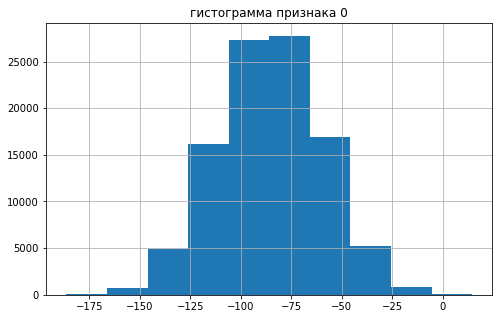

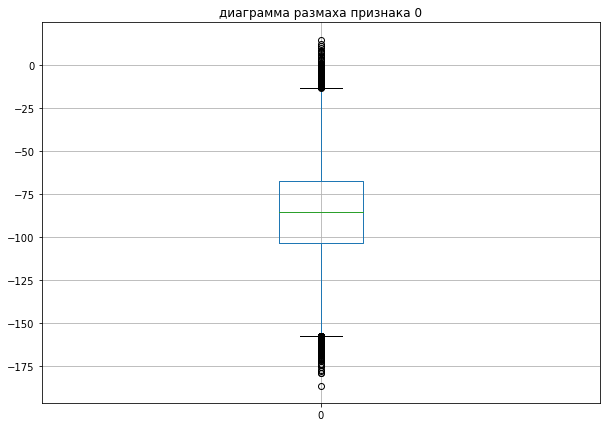

аномальные заначения признака 0: > -13.363303750000007, < -157.27665374999998
Данные признака 1
count    100000.000000
mean          7.664345
std           4.955651
min         -11.560507
25%           4.313784
50%           7.652854
75%          10.981191
max          28.917845
Name: 1, dtype: float64


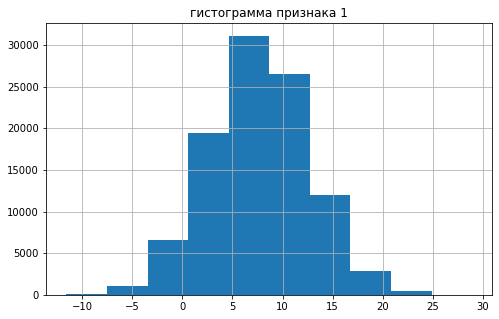

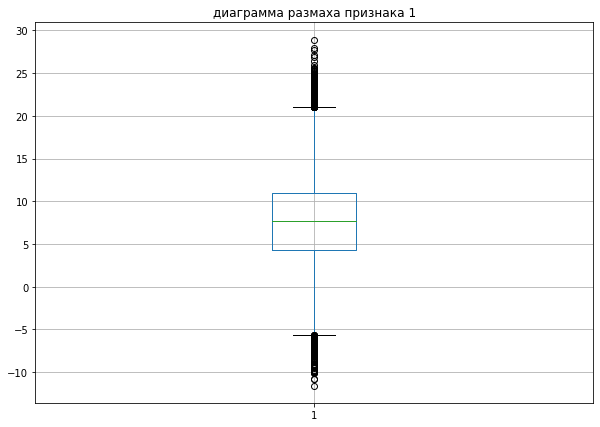

аномальные заначения признака 1: > 20.982300725, < -5.687325875000001
Данные признака 2
count    100000.000000
mean        -43.667046
std          39.111064
min        -224.896060
25%         -69.494487
50%         -42.830246
75%         -17.713690
max         128.108460
Name: 2, dtype: float64


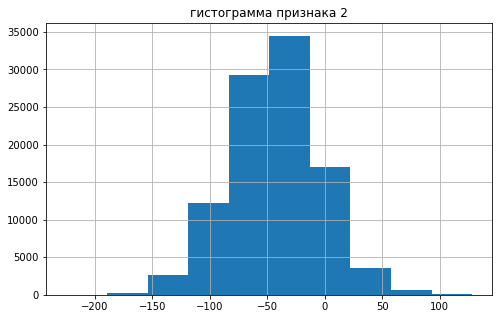

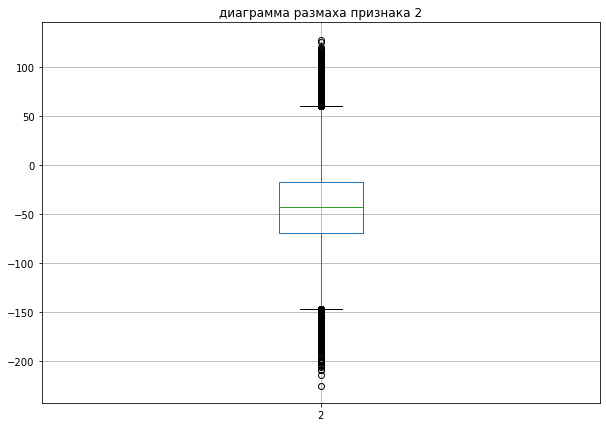

аномальные заначения признака 2: > 59.95750749999998, < -147.16568449999997
Данные признака 3
count    100000.000000
mean       -146.118630
std          20.434841
min        -223.307220
25%        -160.028520
50%        -146.067445
75%        -132.277745
max         -60.751625
Name: 3, dtype: float64


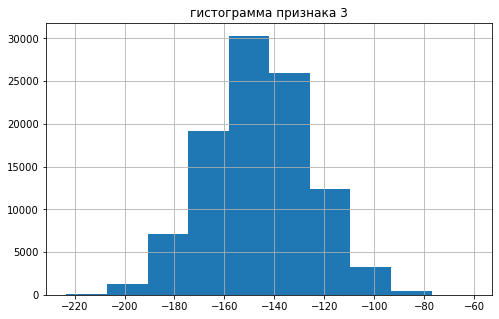

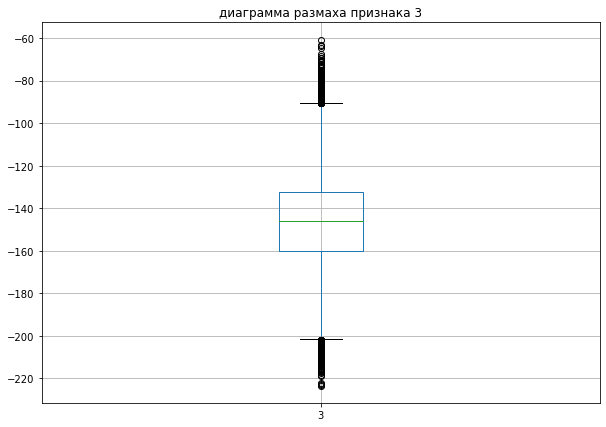

аномальные заначения признака 3: > -90.6515825, < -201.65468250000004
Данные признака 4
count    100000.000000
mean        111.770592
std          47.700958
min         -93.272020
25%          79.474322
50%         112.260100
75%         143.760830
max         301.363600
Name: 4, dtype: float64


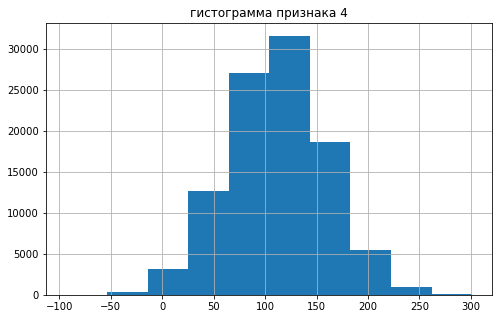

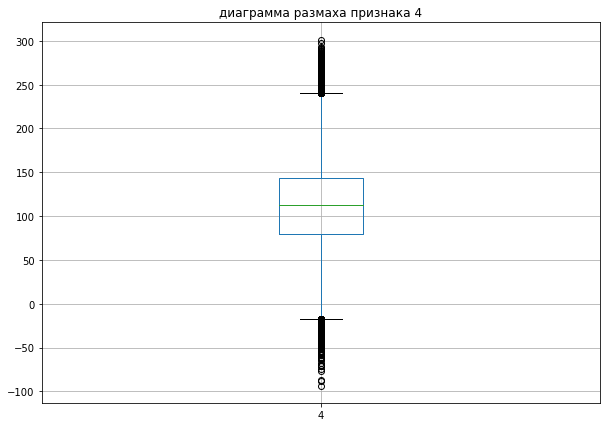

аномальные заначения признака 4: > 240.19059125, < -16.95543875
Данные признака 5
count    100000.000000
mean        -73.178792
std          28.718853
min        -184.962450
25%         -92.834080
50%         -73.364420
75%         -53.699612
max          51.849710
Name: 5, dtype: float64


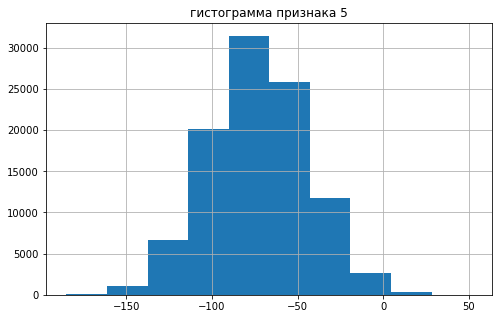

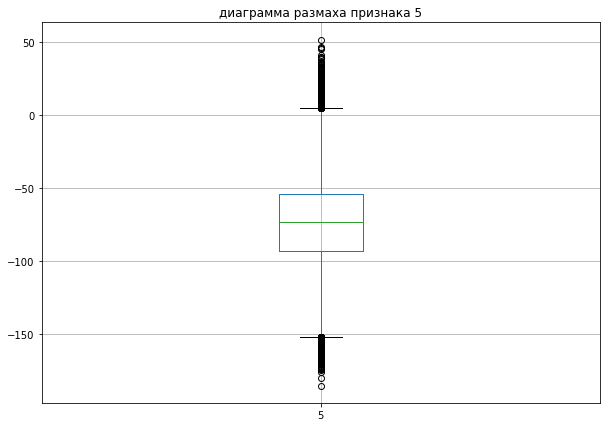

аномальные заначения признака 5: > 5.002088624999999, < -151.535780375
Данные признака 6
count    100000.000000
mean       -440.615118
std         279.017550
min        -791.469482
25%        -738.536868
50%        -511.837758
75%        -201.116578
max         109.625188
Name: 6, dtype: float64


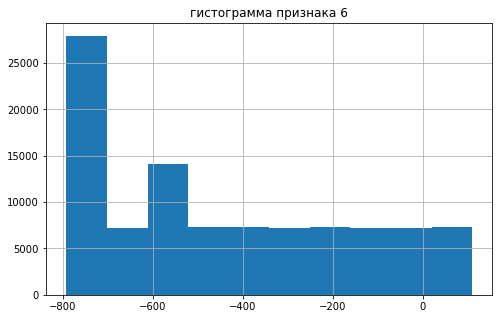

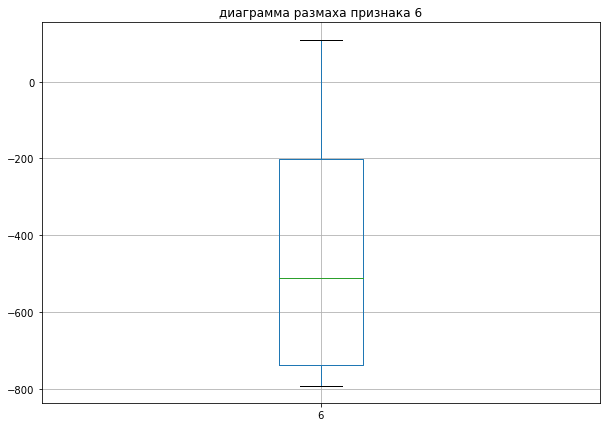

аномальные заначения признака 6: > 605.0138586868352, < -1544.6673046896076
Данные признака 7
count    100000.000000
mean         21.231588
std          65.985214
min        -278.582820
25%         -22.131764
50%          22.278989
75%          65.899595
max         288.171840
Name: 7, dtype: float64


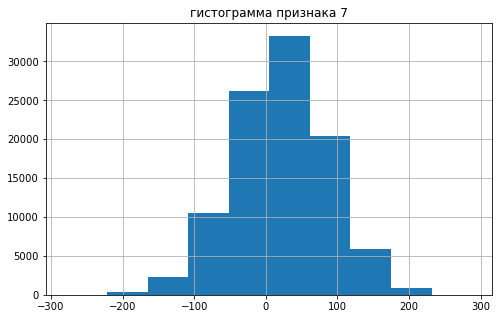

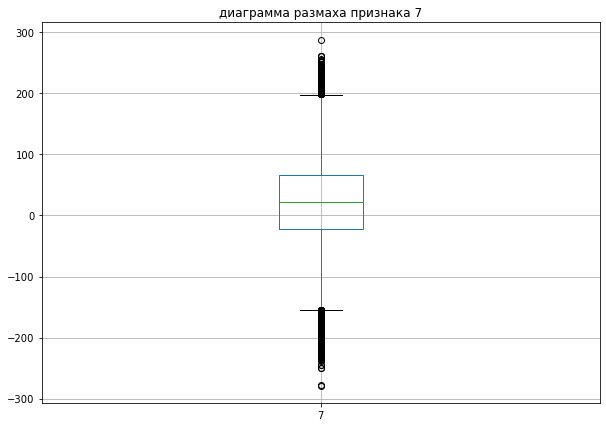

аномальные заначения признака 7: > 197.94663275000002, < -154.17880125000002
Данные признака 8
count    100000.000000
mean        123.067891
std           6.492081
min          94.831150
25%         118.674642
50%         123.087540
75%         127.541802
max         149.356200
Name: 8, dtype: float64


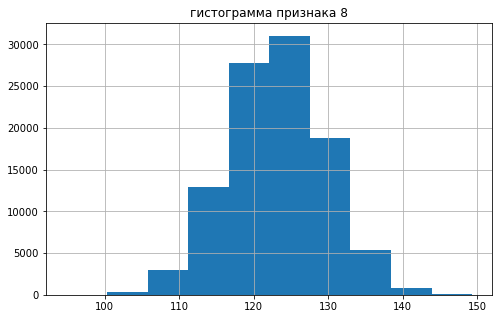

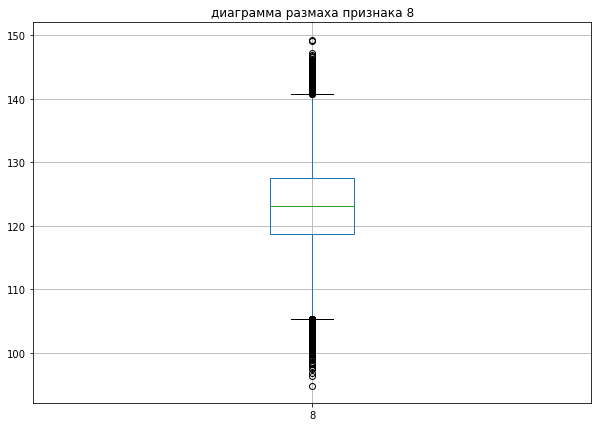

аномальные заначения признака 8: > 140.84254249999998, < 105.37390249999999
Данные признака 9
count    100000.000000
mean        126.120201
std          64.912752
min        -142.156950
25%          82.545028
50%         125.963340
75%         169.701005
max         392.827150
Name: 9, dtype: float64


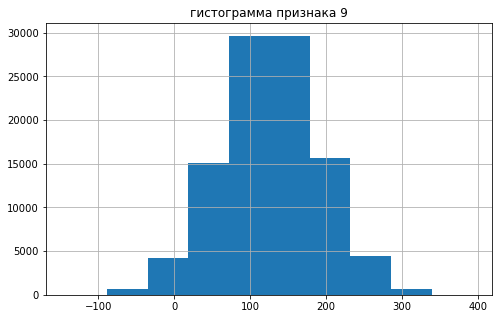

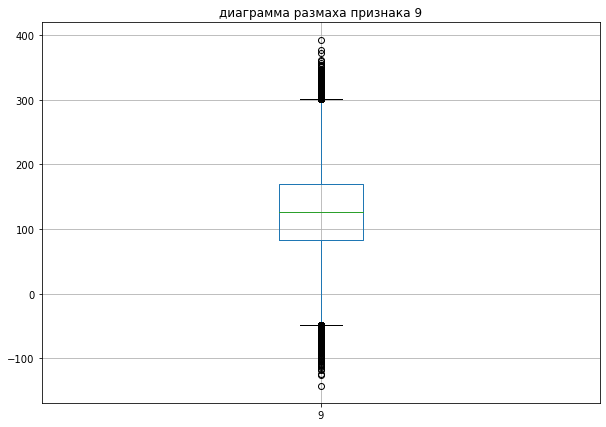

аномальные заначения признака 9: > 300.43497125, < -48.188938750000005
Данные признака 10
count    100000.000000
mean       -141.168584
std          41.607785
min        -330.570600
25%        -168.599020
50%        -140.461440
75%        -113.136535
max          37.017212
Name: 10, dtype: float64


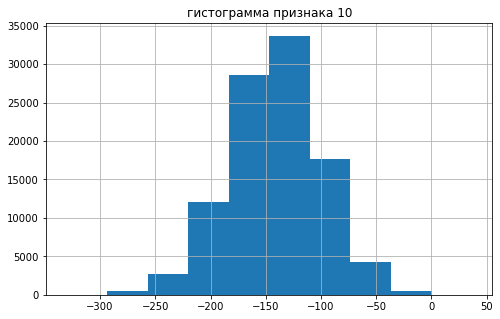

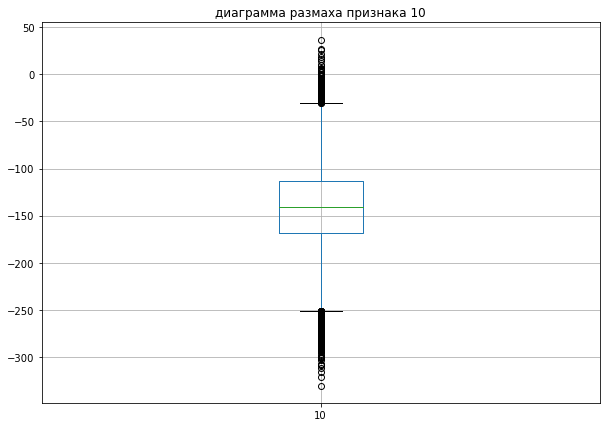

аномальные заначения признака 10: > -29.9428075, < -251.7927475
Данные признака 11
count    100000.000000
mean        -69.228444
std          51.258647
min        -352.405200
25%        -103.048815
50%         -68.753325
75%         -34.668559
max         152.500000
Name: 11, dtype: float64


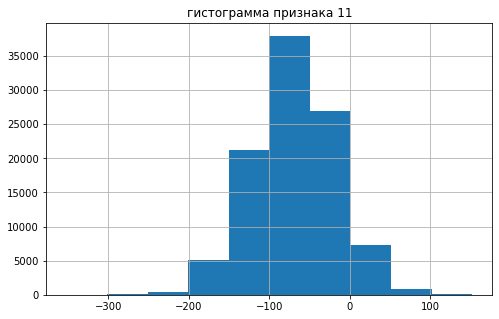

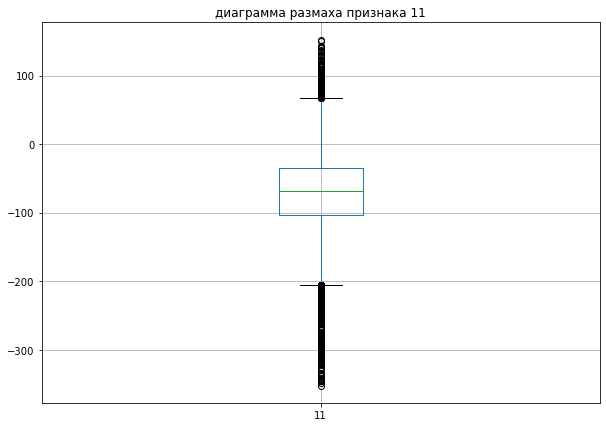

аномальные заначения признака 11: > 67.901825625, < -205.619199375
Данные признака 12
count    100000.000000
mean        -42.559541
std          40.819544
min        -214.742460
25%         -69.801705
50%         -41.919796
75%         -14.631057
max         116.210100
Name: 12, dtype: float64


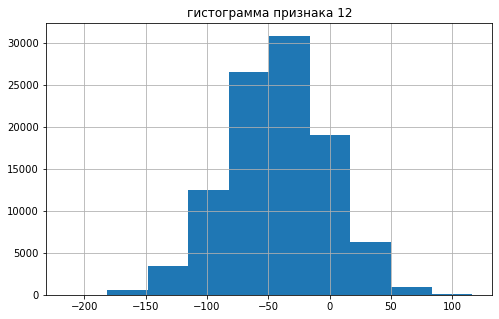

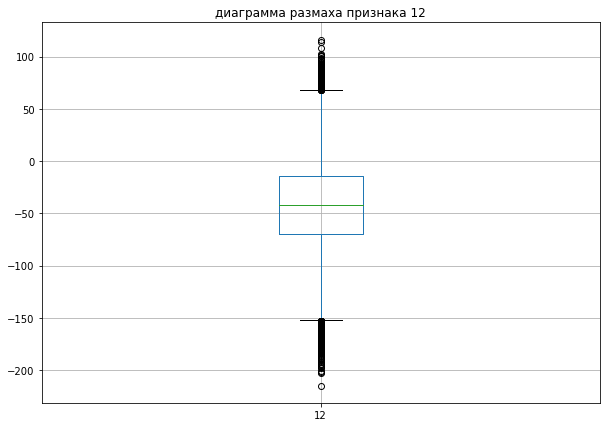

аномальные заначения признака 12: > 68.124915625, < -152.557677375
Данные признака 13
count    100000.000000
mean          6.506719
std          37.593800
min        -145.860280
25%         -18.815189
50%           6.739488
75%          32.074534
max         171.126970
Name: 13, dtype: float64


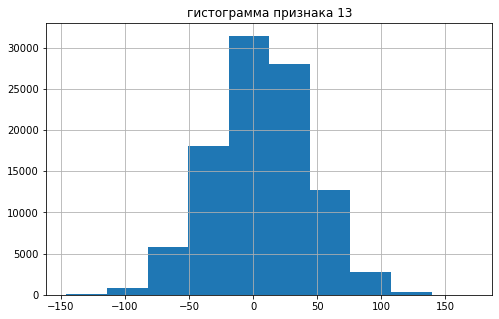

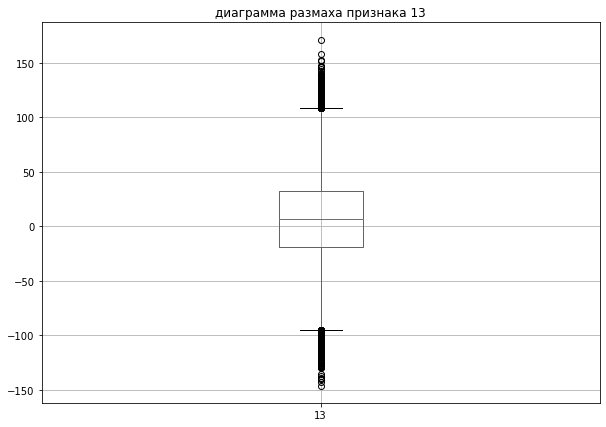

аномальные заначения признака 13: > 108.409118625, < -95.149774375
Данные признака 14
count    100000.000000
mean        149.077582
std          34.167843
min           8.818390
25%         126.369124
50%         149.705675
75%         172.627318
max         279.152560
Name: 14, dtype: float64


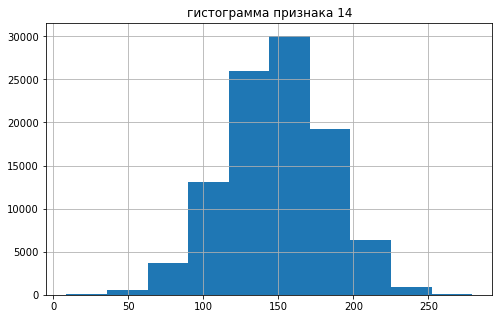

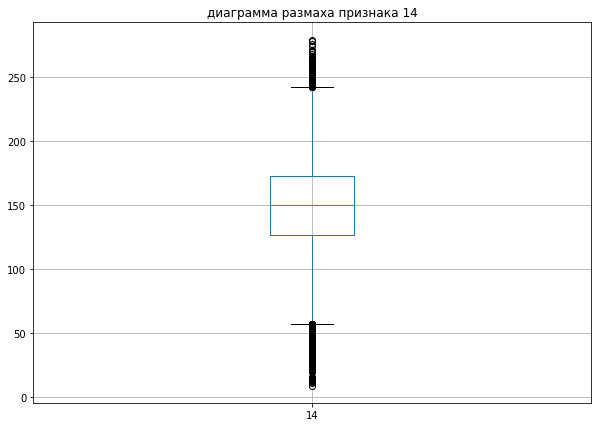

аномальные заначения признака 14: > 242.014608125, < 56.981833124999994
Данные признака 15
count    100000.000000
mean        -23.942253
std          13.024184
min         -82.645004
25%         -32.379752
50%         -23.707227
75%         -15.438074
max          35.552612
Name: 15, dtype: float64


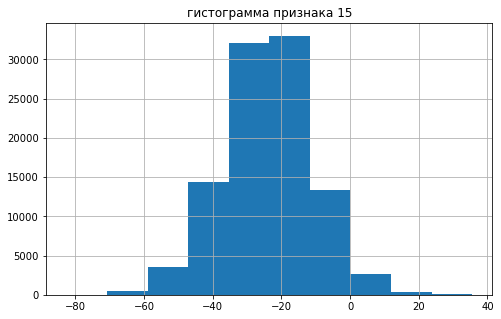

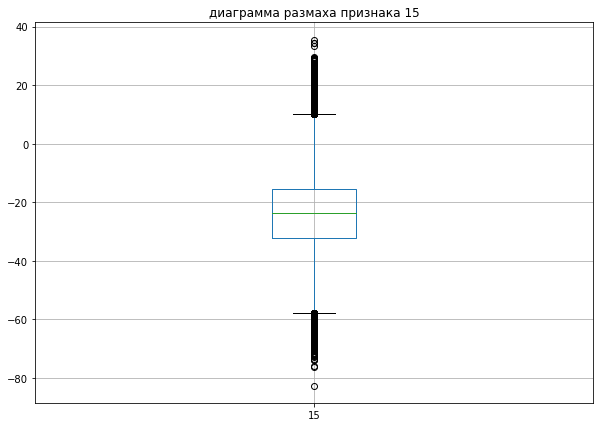

аномальные заначения признака 15: > 9.974442875000006, < -57.79226812500001
Данные признака 16
count    100000.000000
mean         -2.219093
std          20.978943
min         -91.657020
25%         -16.455603
50%          -2.339008
75%          11.702535
max          94.324580
Name: 16, dtype: float64


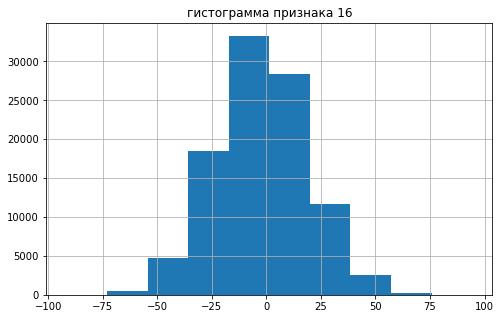

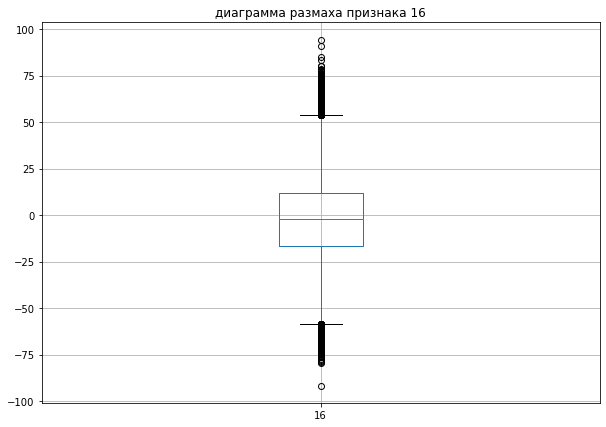

аномальные заначения признака 16: > 53.939742374999994, < -58.69281062499999
Данные признака 17
count    100000.000000
mean        -12.964439
std          55.210920
min        -247.589280
25%         -49.612492
50%         -12.189709
75%          24.464662
max         215.488050
Name: 17, dtype: float64


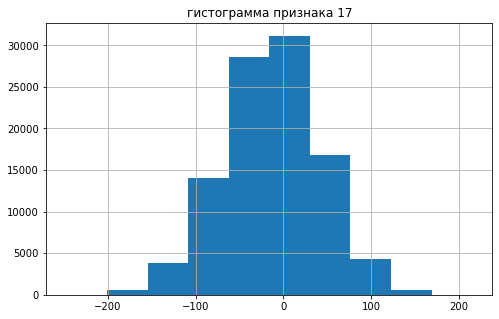

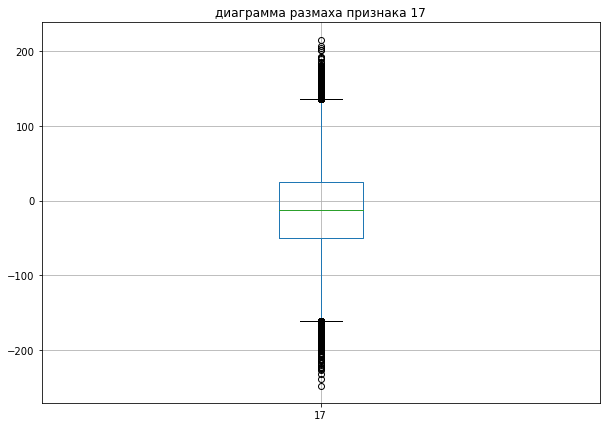

аномальные заначения признака 17: > 135.580392875, < -160.728222125
Данные признака 18
count    100000.000000
mean       -138.714610
std          48.737245
min        -326.648740
25%        -171.661355
50%        -139.009150
75%        -106.746862
max          79.245160
Name: 18, dtype: float64


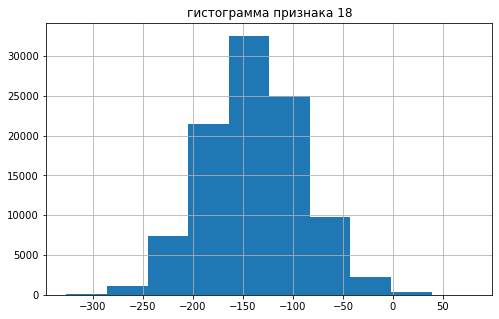

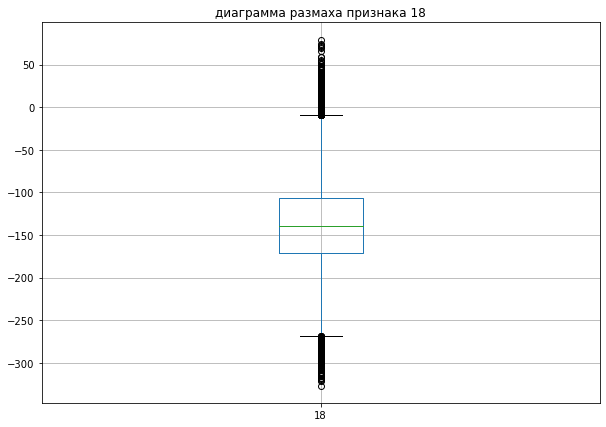

аномальные заначения признака 18: > -9.375123749999958, < -269.03309375000003
Данные признака 19
count    100000.000000
mean        -79.159795
std           0.775560
min         -82.637184
25%         -79.656816
50%         -79.137460
75%         -78.638890
max         -75.835640
Name: 19, dtype: float64


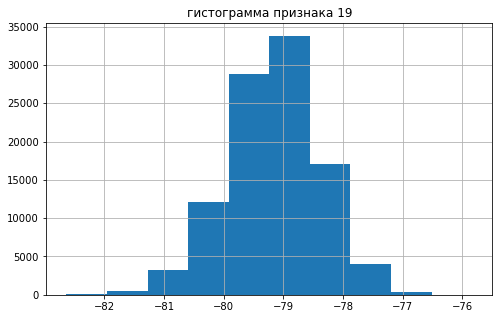

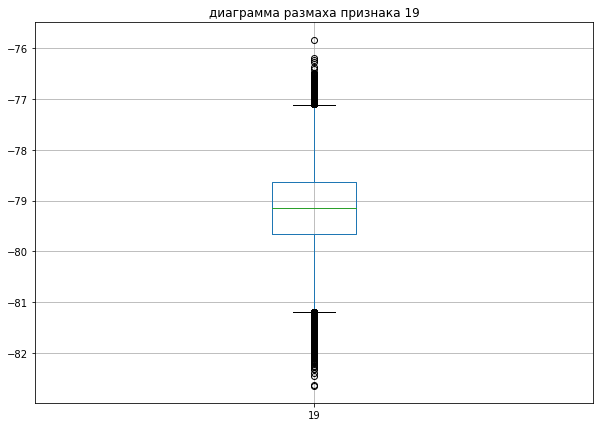

аномальные заначения признака 19: > -77.11200062500002, < -81.18370562499997
Данные признака 20
count    100000.000000
mean        -97.474574
std          28.382144
min        -228.808260
25%        -115.407545
50%         -96.862695
75%         -78.583615
max          26.484070
Name: 20, dtype: float64


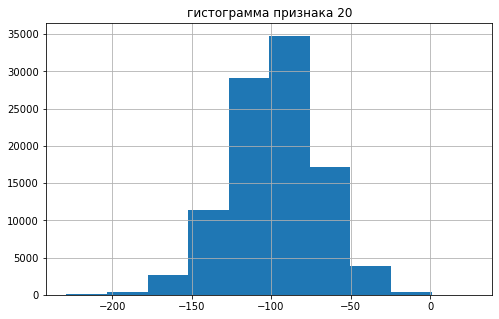

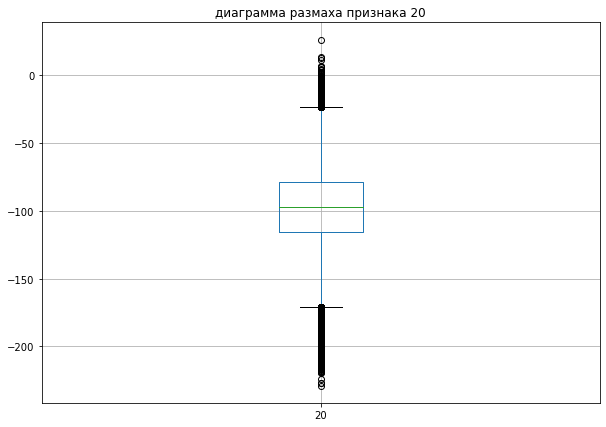

аномальные заначения признака 20: > -23.347720750000022, < -170.64343874999997
Данные признака 21
count    100000.000000
mean       1297.269578
std         375.123794
min         136.873137
25%        1248.126198
50%        1507.231274
75%        1507.231274
max        1557.383334
Name: 21, dtype: float64


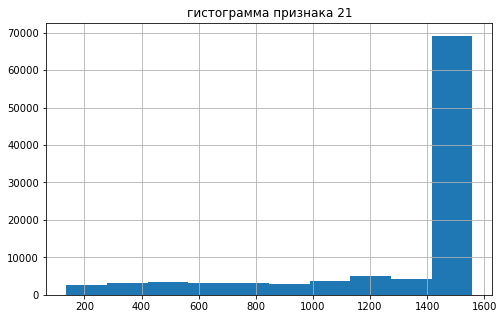

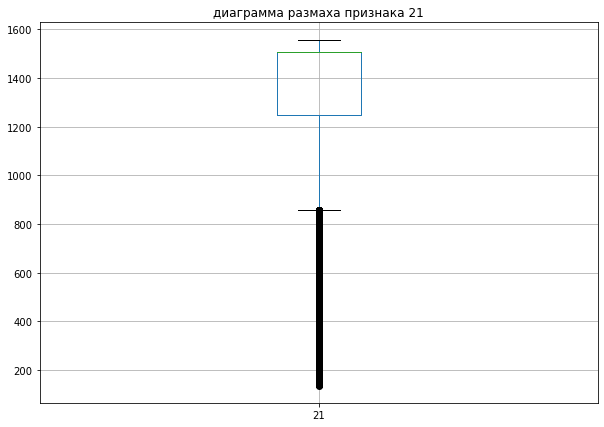

аномальные заначения признака 21: > 1895.88888858598, < 859.4685836086461
Данные признака 22
count    100000.000000
mean         -3.600685
std          50.063680
min        -211.971800
25%         -37.047511
50%          -3.608930
75%          29.473402
max         193.884310
Name: 22, dtype: float64


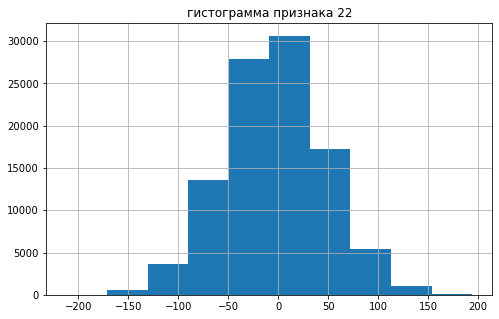

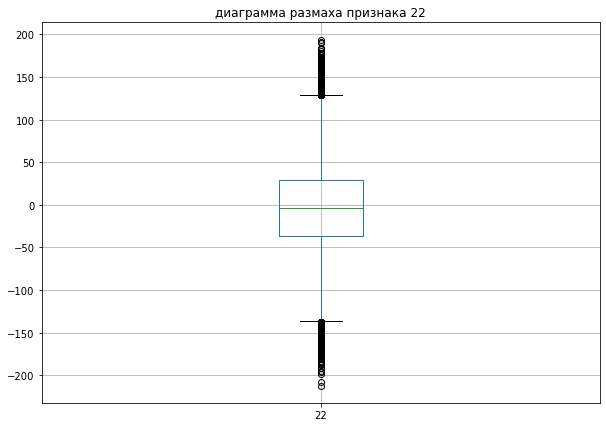

аномальные заначения признака 22: > 129.25477225, < -136.82888175
Данные признака 23
count    100000.000000
mean         55.908014
std          35.617513
min         -87.323780
25%          31.436791
50%          55.273705
75%          79.557540
max         207.021060
Name: 23, dtype: float64


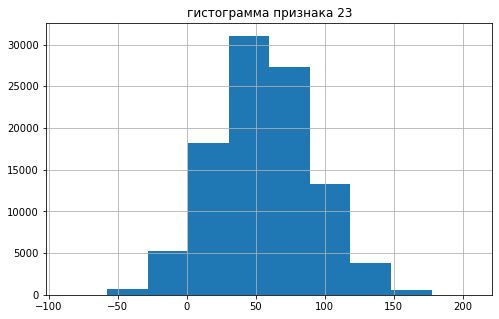

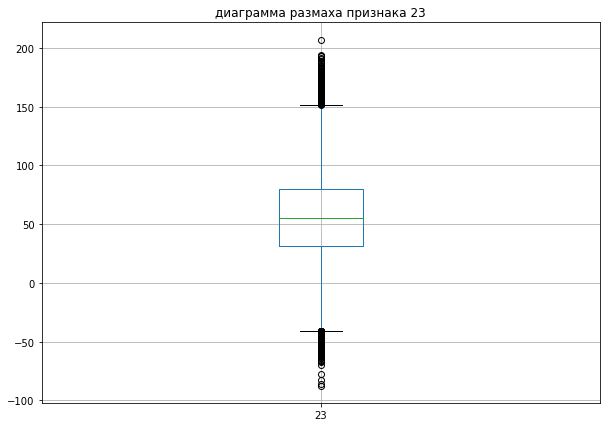

аномальные заначения признака 23: > 151.738663875, < -40.744333125
Данные признака 24
count    100000.000000
mean         23.470181
std          40.802653
min        -122.584274
25%          -5.051067
50%          23.306557
75%          51.787124
max         199.461760
Name: 24, dtype: float64


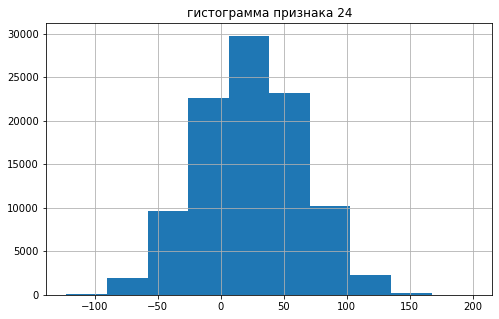

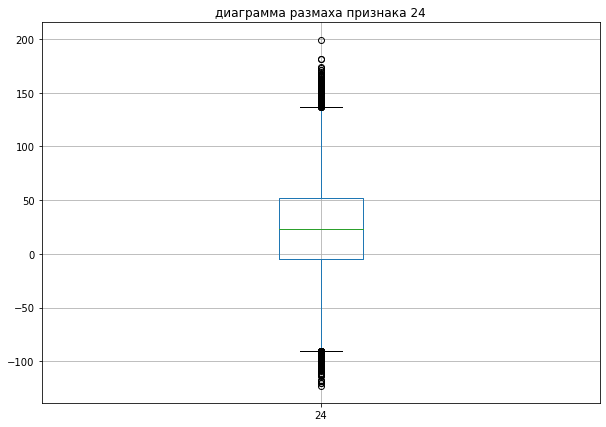

аномальные заначения признака 24: > 137.0444104, < -90.308354
Данные признака 25
count    100000.000000
mean        742.788817
std         191.052074
min         -61.803358
25%         813.770071
50%         813.770071
75%         813.770071
max         845.708887
Name: 25, dtype: float64


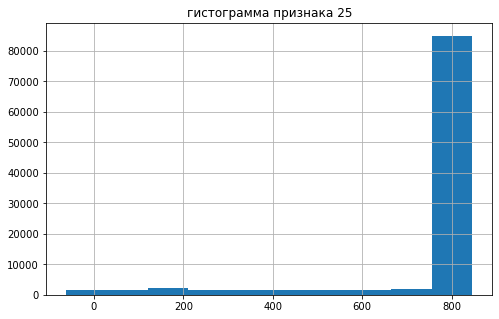

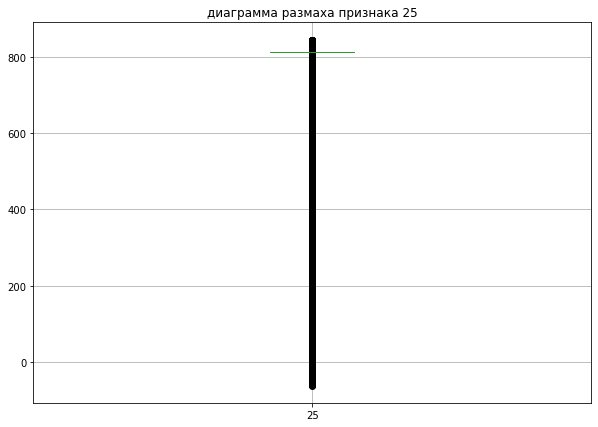

аномальные заначения признака 25: > 813.7700714289165, < 813.7700714289165
Данные признака 26
count    100000.000000
mean        -64.970553
std          63.160650
min        -338.562500
25%        -106.860569
50%         -65.226217
75%         -22.893323
max         192.107970
Name: 26, dtype: float64


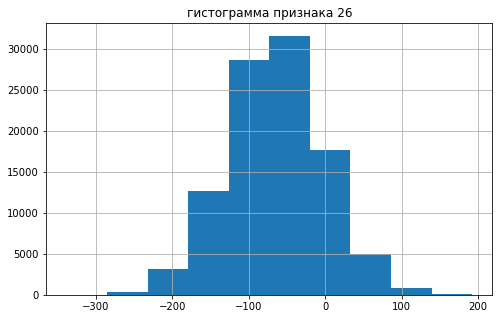

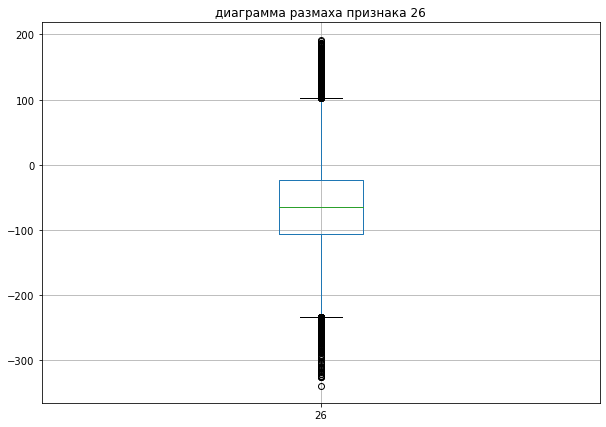

аномальные заначения признака 26: > 103.05754674999997, < -232.81143924999998
Данные признака 27
count    100000.000000
mean         16.368072
std           4.828575
min          -6.629074
25%          13.187895
50%          16.473505
75%          19.662112
max          35.112410
Name: 27, dtype: float64


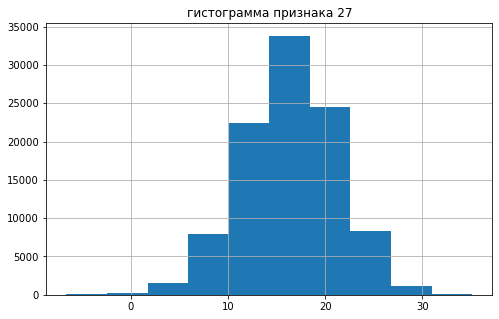

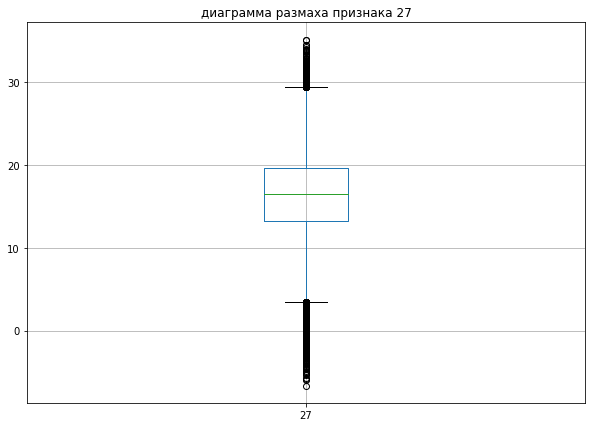

аномальные заначения признака 27: > 29.373436125000005, < 3.4765711249999978
Данные признака 28
count    100000.000000
mean        -86.201170
std          49.511818
min        -285.668700
25%        -119.613590
50%         -86.514155
75%         -53.064181
max         101.514206
Name: 28, dtype: float64


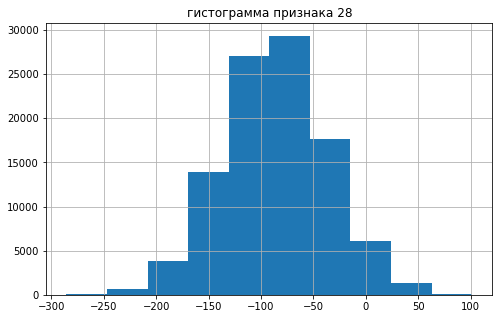

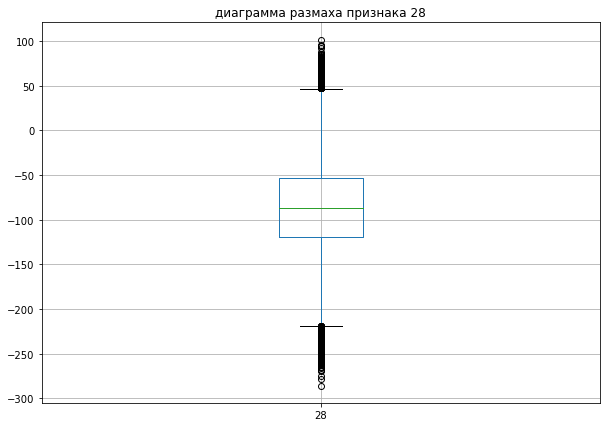

аномальные заначения признака 28: > 46.75993249999999, < -219.4377035
Данные признака 29
count    100000.000000
mean        152.098083
std          10.392531
min         111.387250
25%         145.143008
50%         151.992225
75%         158.893878
max         195.698560
Name: 29, dtype: float64


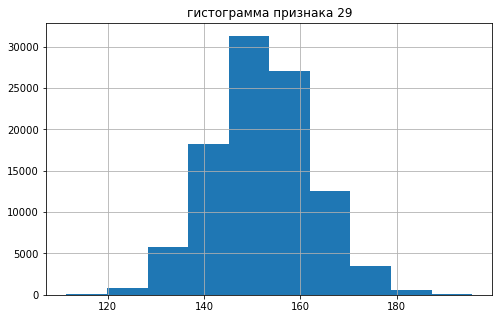

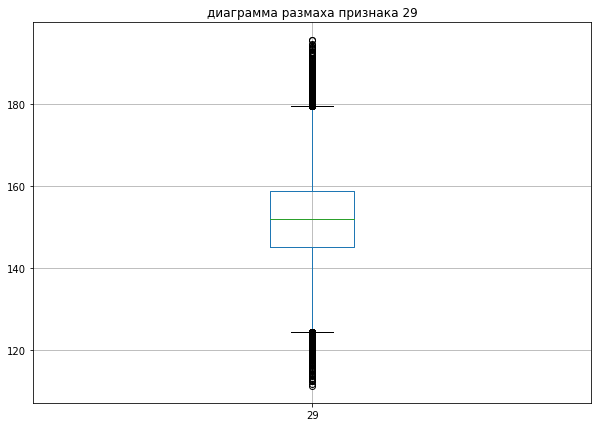

аномальные заначения признака 29: > 179.52018249999998, < 124.51670250000002
Данные признака 30
count    100000.000000
mean        -13.659323
std          29.191689
min        -130.444920
25%         -32.812503
50%         -13.218622
75%           5.975015
max         102.204050
Name: 30, dtype: float64


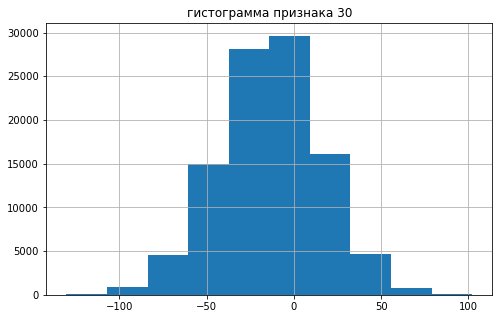

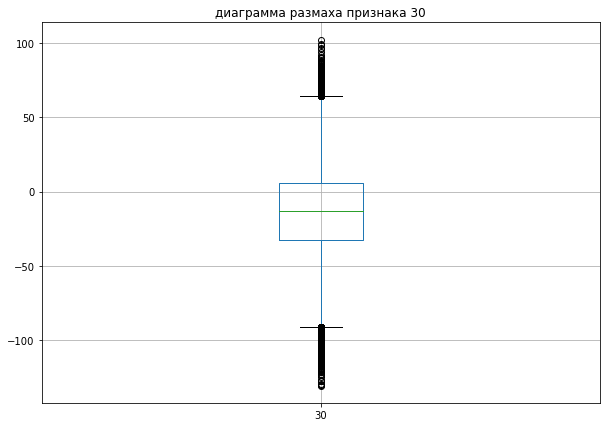

аномальные заначения признака 30: > 64.1562918125, < -90.9937790875
Данные признака 31
count    100000.000000
mean       -144.506022
std          35.816357
min        -290.124000
25%        -168.535163
50%        -144.584500
75%        -120.439300
max          10.103592
Name: 31, dtype: float64


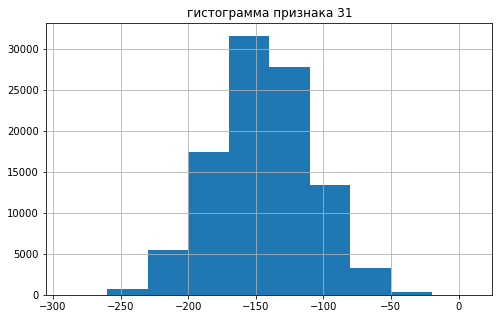

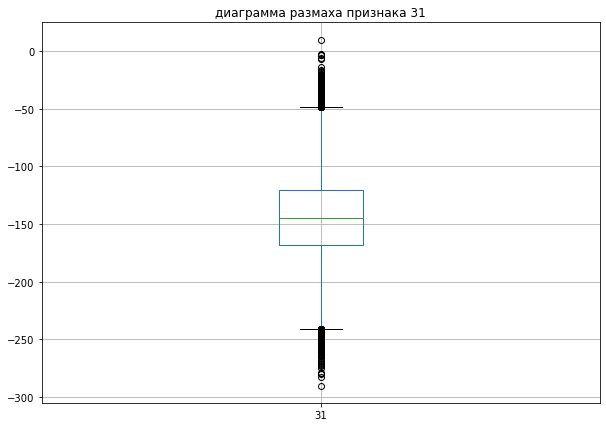

аномальные заначения признака 31: > -48.29550624999999, < -240.67895625000003
Данные признака 32
count    100000.000000
mean         89.747894
std          28.312124
min         -25.550720
25%          70.432237
50%          89.966625
75%         109.219697
max         198.149780
Name: 32, dtype: float64


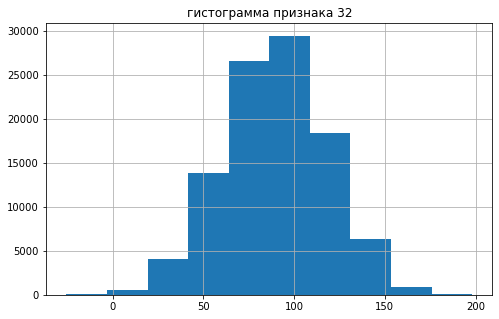

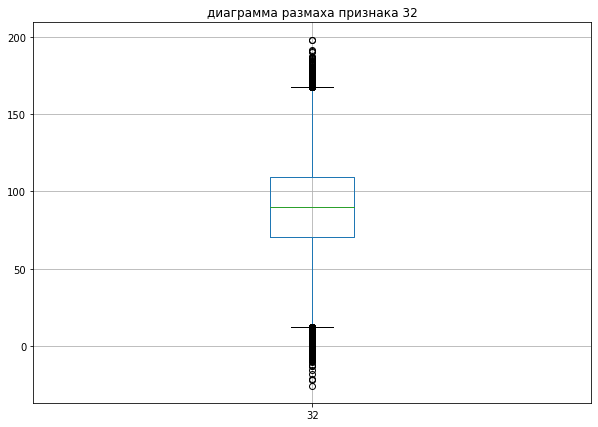

аномальные заначения признака 32: > 167.40088749999998, < 12.251047500000006
Данные признака 33
count    100000.000000
mean       -587.551768
std         273.294442
min       -1044.135662
25%        -803.390708
50%        -579.590387
75%        -349.545030
max        -137.646757
Name: 33, dtype: float64


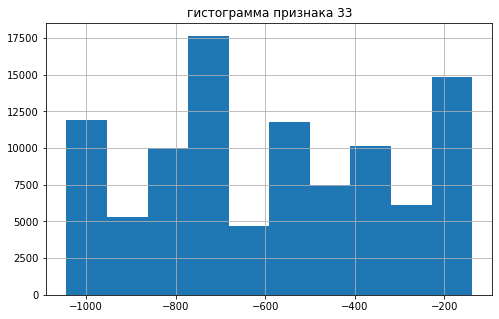

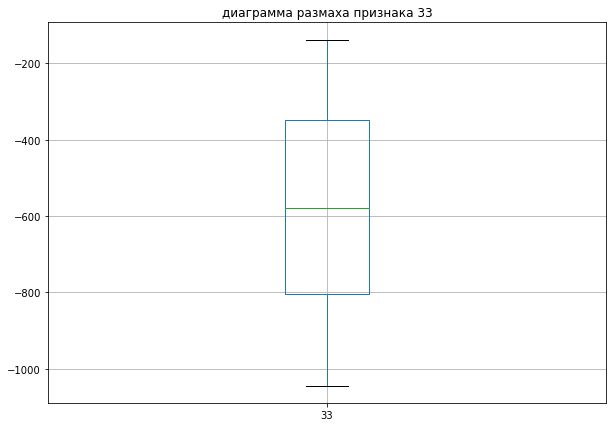

аномальные заначения признака 33: > 331.2234874979216, < -1484.1592246308187
Данные признака 34
count    100000.000000
mean         36.468210
std          39.756311
min        -119.903810
25%           9.505674
50%          36.398791
75%          63.628358
max         206.765240
Name: 34, dtype: float64


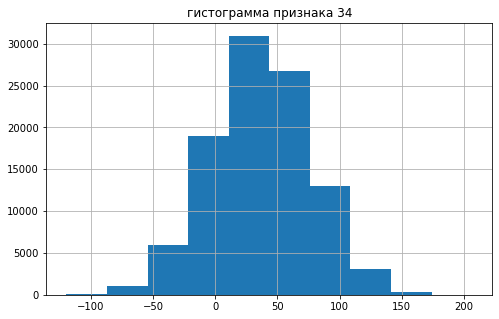

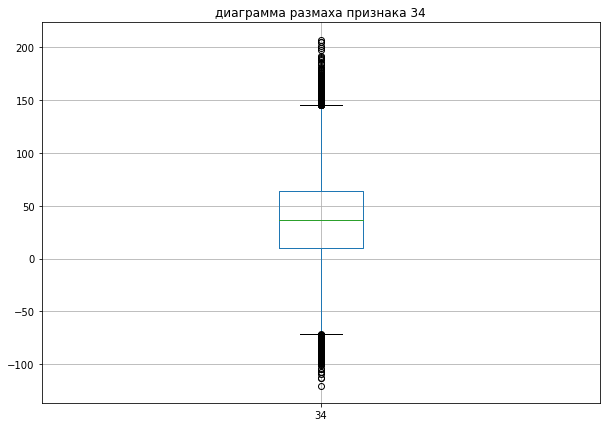

аномальные заначения признака 34: > 144.81238237500003, < -71.67835062500001
Данные признака 35
count    100000.000000
mean         73.109595
std          20.008170
min         -11.926712
25%          59.978086
50%          73.121085
75%          86.277285
max         156.648200
Name: 35, dtype: float64


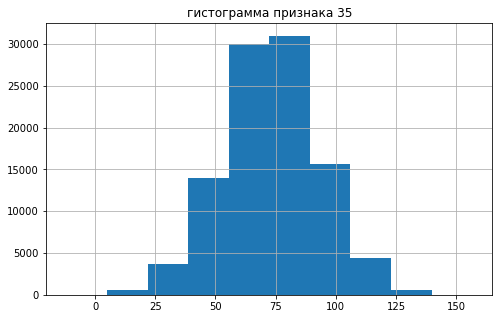

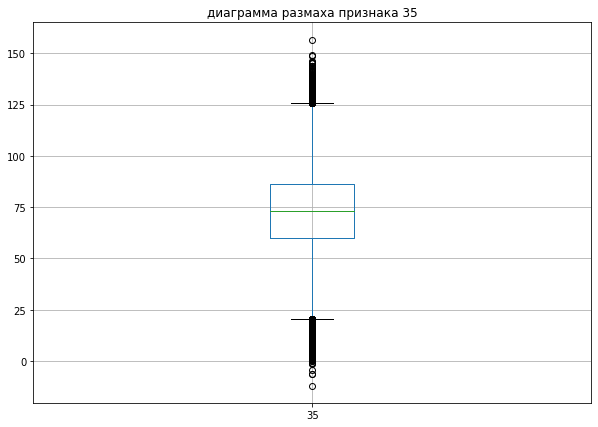

аномальные заначения признака 35: > 125.726083125, < 20.529288125
Данные признака 36
count    100000.000000
mean        -13.866967
std          25.824911
min        -124.560380
25%         -30.926924
50%         -13.399444
75%           3.638963
max          87.089355
Name: 36, dtype: float64


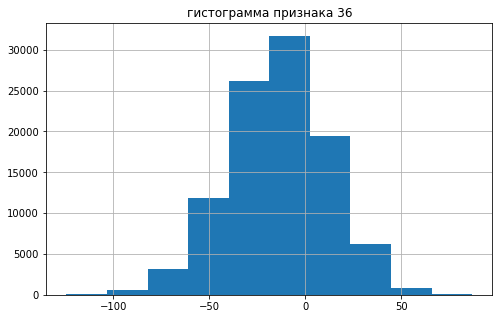

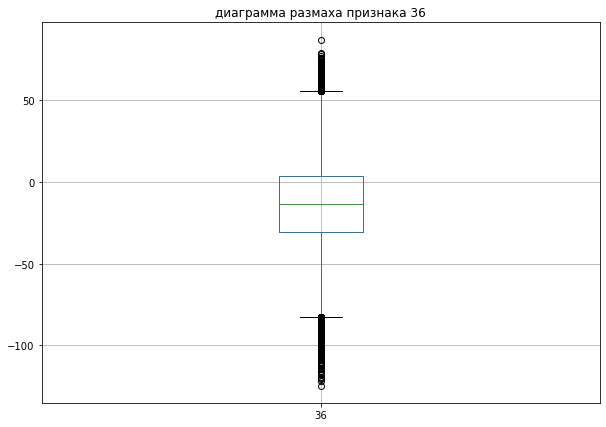

аномальные заначения признака 36: > 55.48779249999999, < -82.7757535
Данные признака 37
count    100000.000000
mean       -146.487267
std          10.383975
min        -193.918150
25%        -153.339210
50%        -146.415015
75%        -139.454015
max        -101.977620
Name: 37, dtype: float64


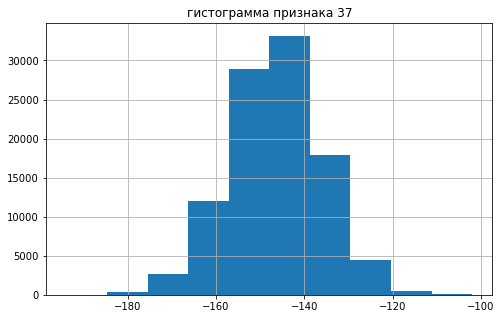

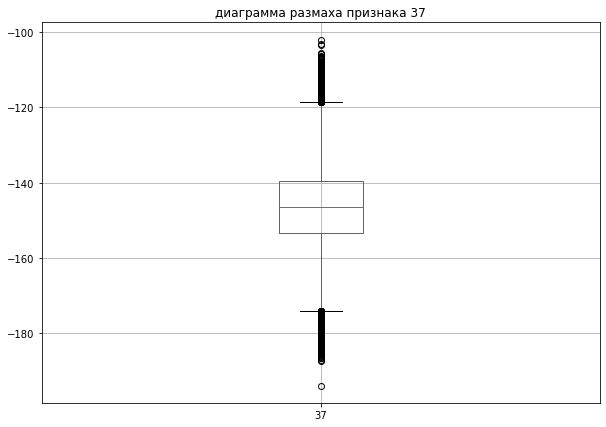

аномальные заначения признака 37: > -118.62622249999998, < -174.16700250000002
Данные признака 38
count    100000.000000
mean       -118.336458
std          13.578397
min        -166.078460
25%        -127.603408
50%        -118.359200
75%        -109.068438
max         -61.248470
Name: 38, dtype: float64


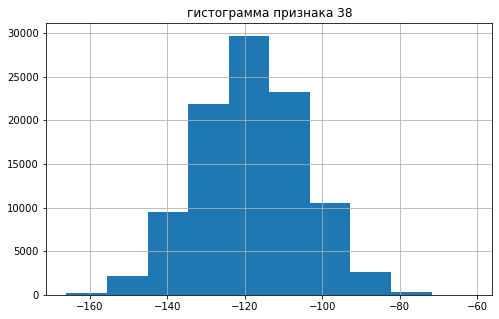

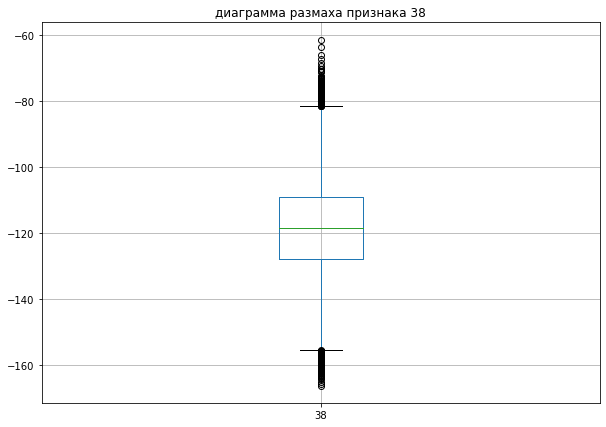

аномальные заначения признака 38: > -81.2659825, < -155.4058625
Данные признака 39
count    100000.000000
mean        -41.131969
std          19.868303
min        -123.062420
25%         -54.589425
50%         -41.346603
75%         -27.693264
max          34.684986
Name: 39, dtype: float64


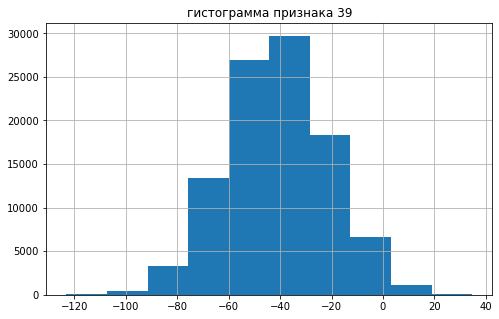

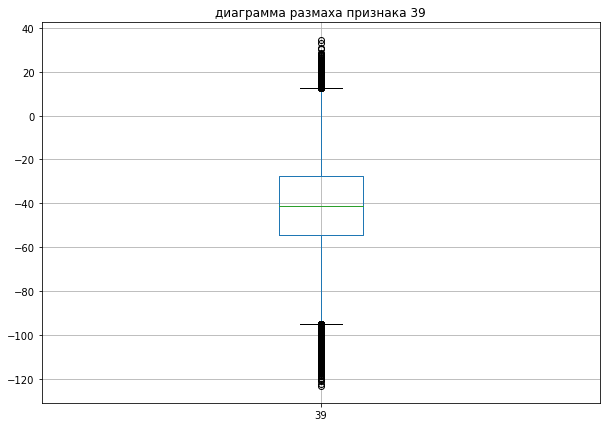

аномальные заначения признака 39: > 12.650976875000012, < -94.93366612500002
Данные признака 40
count    100000.000000
mean         -9.261504
std           8.295381
min         -43.063824
25%         -14.772180
50%          -9.213719
75%          -3.671712
max          24.319061
Name: 40, dtype: float64


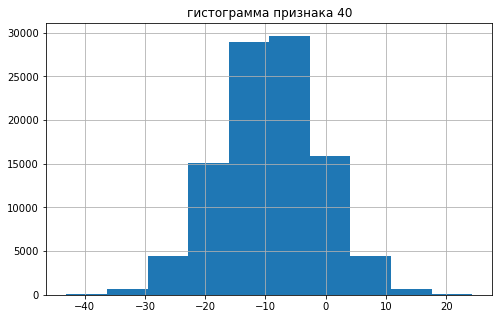

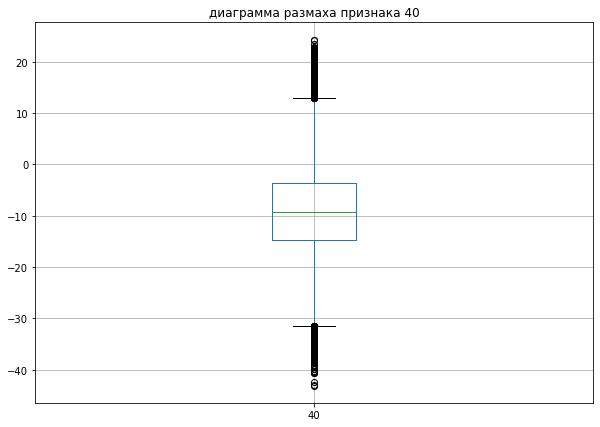

аномальные заначения признака 40: > 12.978990874999997, < -31.422882924999996
Данные признака 41
count    100000.000000
mean          4.139978
std           5.922103
min         -18.980648
25%           0.086251
50%           4.213268
75%           8.247889
max          25.914757
Name: 41, dtype: float64


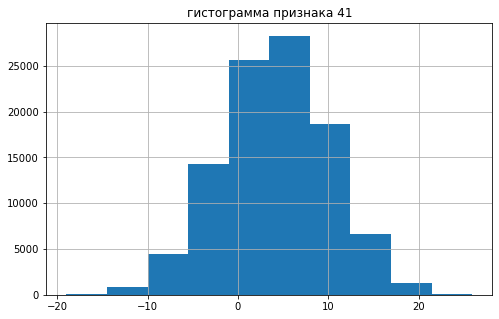

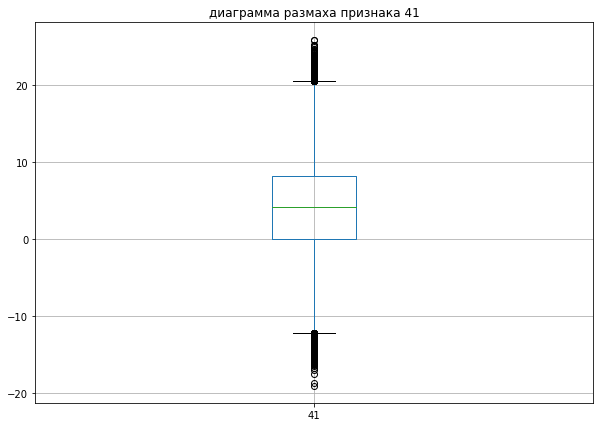

аномальные заначения признака 41: > 20.490344004500002, < -12.156204007500001
Данные признака 42
count    100000.000000
mean       -104.928806
std          56.519443
min        -324.943570
25%        -144.015452
50%        -106.112495
75%         -66.750507
max         116.187910
Name: 42, dtype: float64


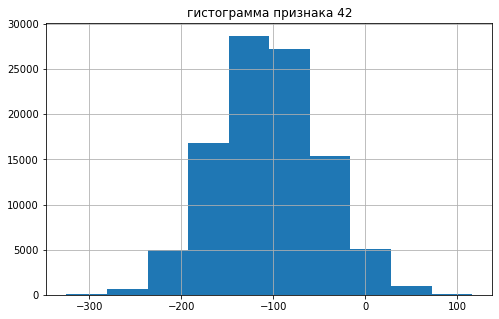

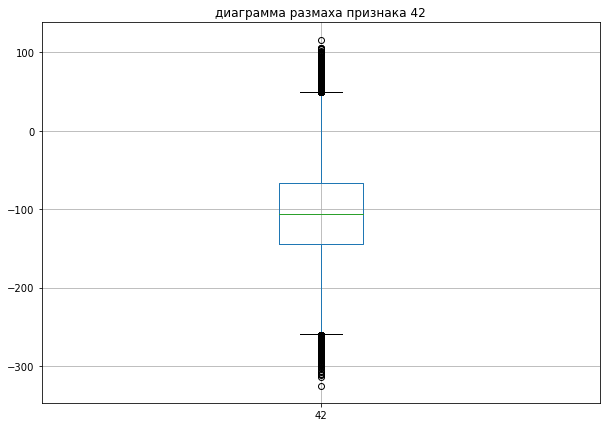

аномальные заначения признака 42: > 49.146911249999974, < -259.91287074999997
Данные признака 43
count    100000.000000
mean        122.240784
std          48.109909
min         -67.540375
25%          89.138641
50%         122.344315
75%         154.744470
max         335.559450
Name: 43, dtype: float64


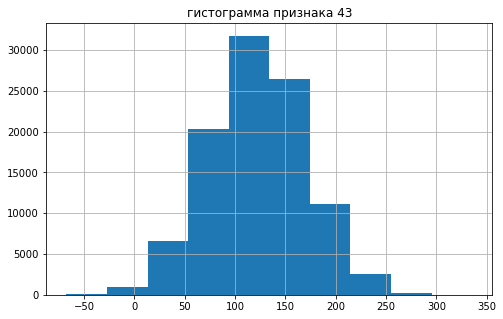

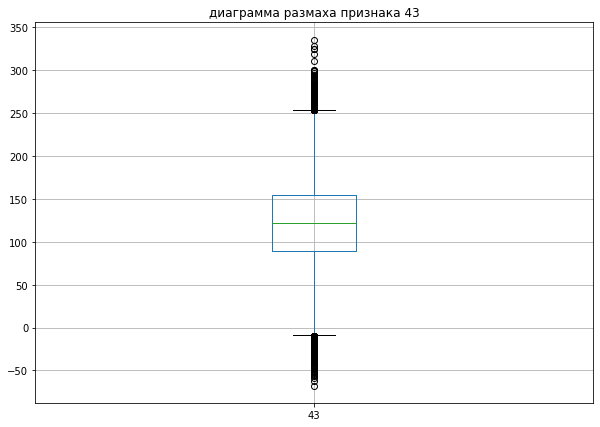

аномальные заначения признака 43: > 253.153213125, < -9.270101874999995
Данные признака 44
count    100000.000000
mean        -40.320211
std          14.739497
min         -63.102401
25%         -53.806738
50%         -39.954565
75%         -26.757267
max         -16.052626
Name: 44, dtype: float64


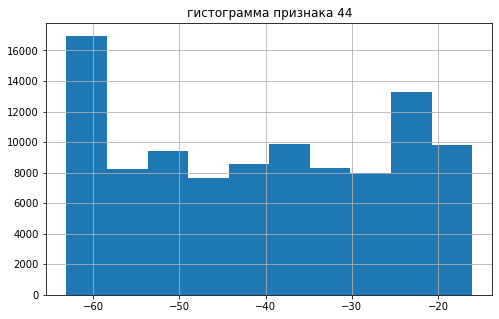

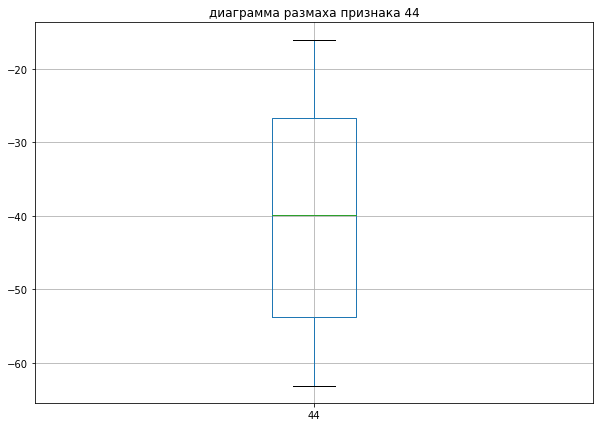

аномальные заначения признака 44: > 13.816938607212343, < -94.38094393519125
Данные признака 45
count    100000.000000
mean         59.051981
std          31.088173
min         -64.789690
25%          37.832466
50%          59.343556
75%          80.604097
max         175.807740
Name: 45, dtype: float64


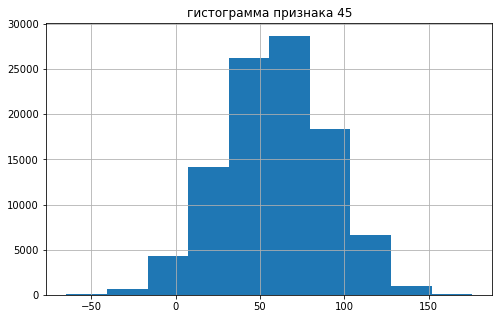

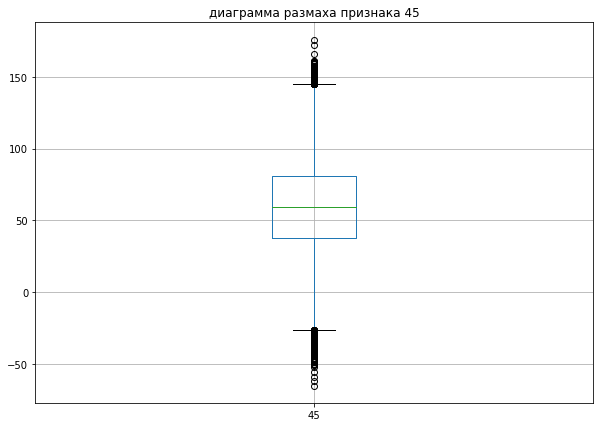

аномальные заначения признака 45: > 144.761544125, < -26.324980874999987
Данные признака 46
count    100000.000000
mean        -84.054387
std          66.055063
min        -327.322720
25%        -129.672705
50%         -85.365553
75%         -39.212476
max         200.449890
Name: 46, dtype: float64


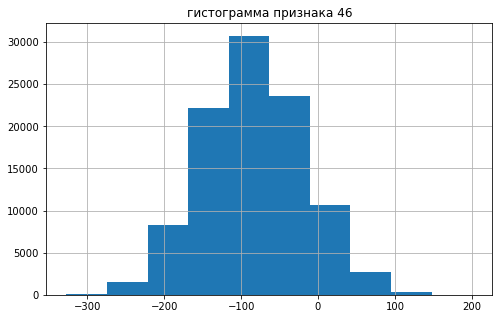

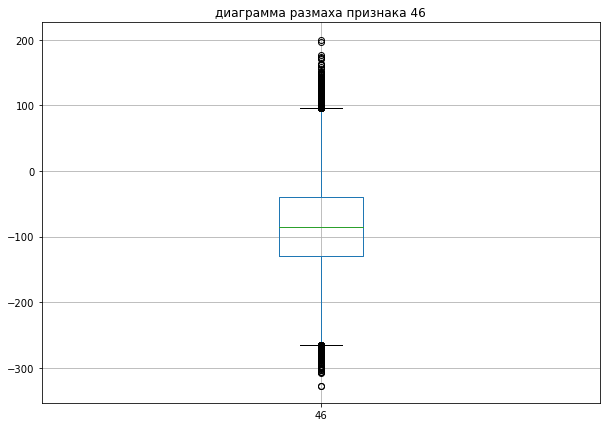

аномальные заначения признака 46: > 96.47786875, < -265.36304925
Данные признака 47
count    100000.000000
mean       -140.787854
std          59.851232
min        -365.060880
25%        -181.176132
50%        -140.503565
75%        -100.564151
max         110.090000
Name: 47, dtype: float64


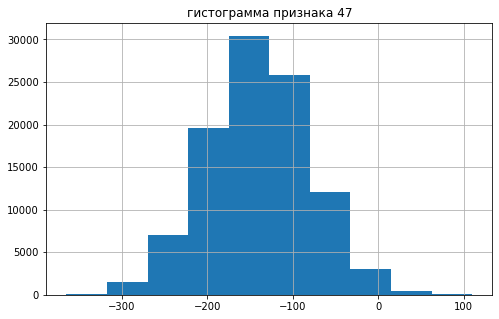

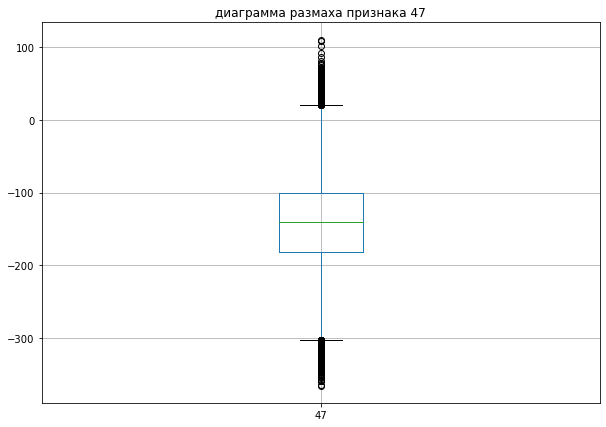

аномальные заначения признака 47: > 20.35382062500001, < -302.09410437500003
Данные признака 48
count    100000.000000
mean         46.137851
std          46.328286
min        -129.879180
25%          14.323097
50%          45.499802
75%          77.578920
max         232.165510
Name: 48, dtype: float64


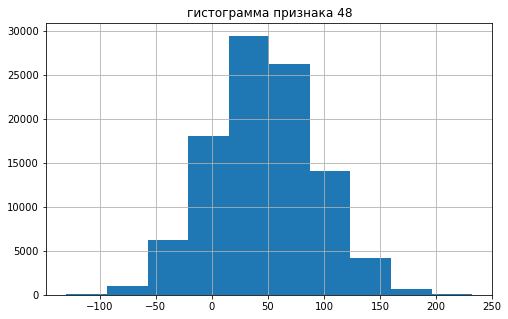

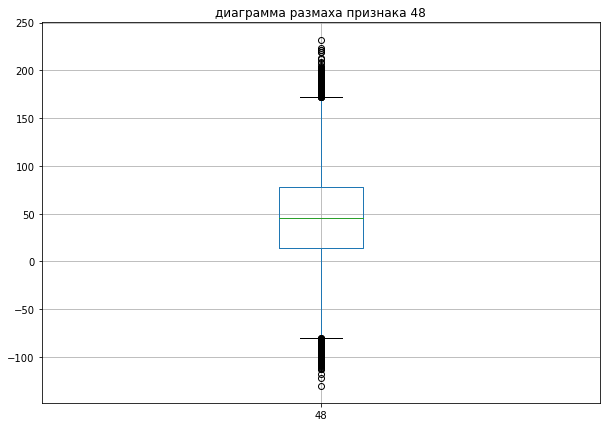

аномальные заначения признака 48: > 172.46265375, < -80.56063624999999
Данные признака 49
count    100000.000000
mean        -34.136875
std          59.325454
min        -280.371830
25%         -73.415320
50%         -31.942193
75%           6.814449
max         191.037410
Name: 49, dtype: float64


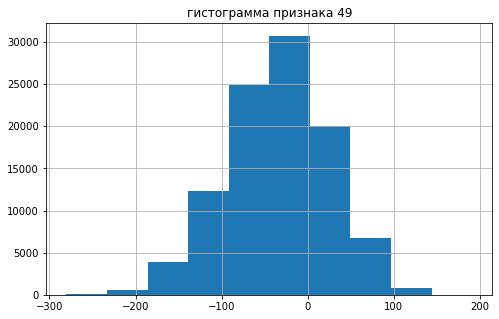

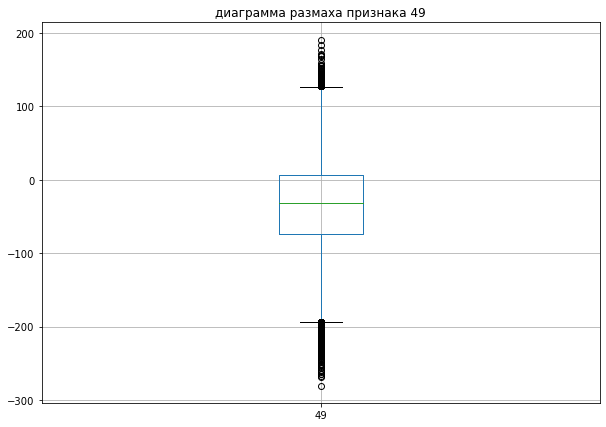

аномальные заначения признака 49: > 127.15910324999999, < -193.75997394999996
Данные признака 50
count    100000.000000
mean         29.462927
std          60.934591
min        -250.337570
25%         -11.033693
50%          30.274884
75%          70.794575
max         257.152400
Name: 50, dtype: float64


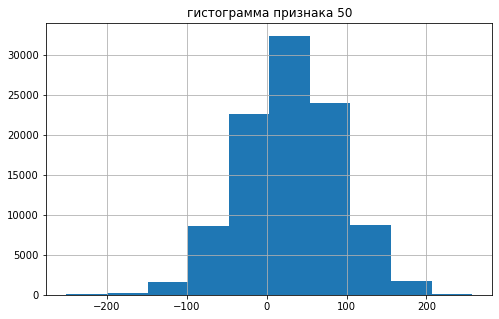

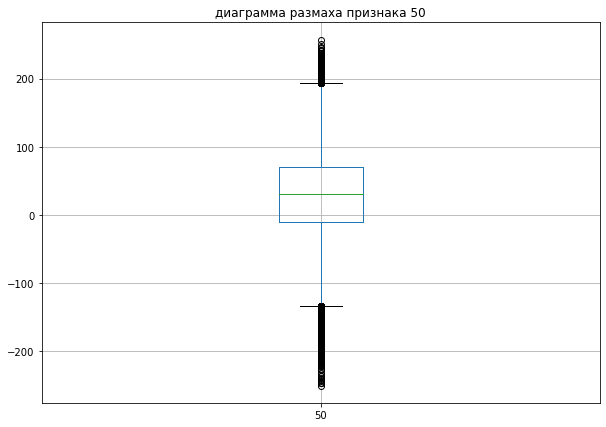

аномальные заначения признака 50: > 193.53697625, < -133.77609375000003
Данные признака 51
count    100000.000000
mean        -22.343451
std          54.991787
min        -236.148470
25%         -59.606014
50%         -23.291442
75%          14.649595
max         212.168600
Name: 51, dtype: float64


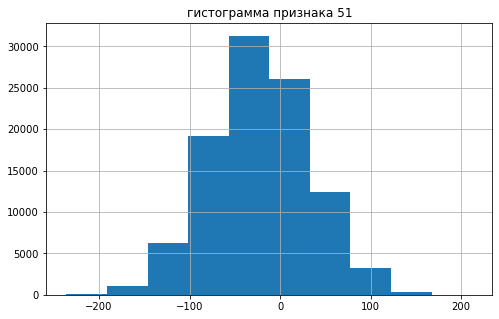

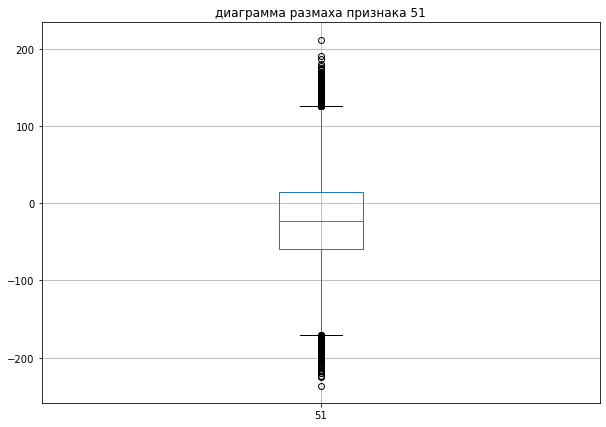

аномальные заначения признака 51: > 126.03300887500001, < -170.98942812500002
Данные признака 52
count    100000.000000
mean         67.581086
std          12.988132
min          18.477040
25%          58.553989
50%          67.261280
75%          76.496660
max         121.795990
Name: 52, dtype: float64


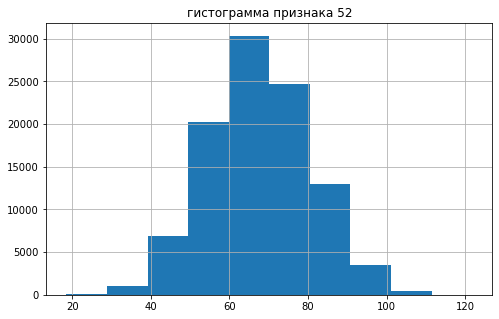

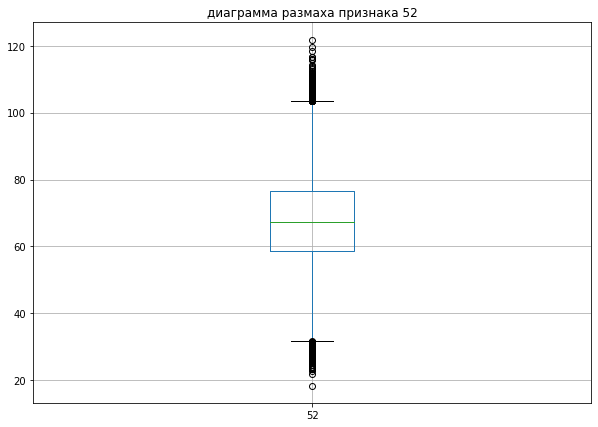

аномальные заначения признака 52: > 103.41066687499998, < 31.639981875000018
Данные признака 53
count    100000.000000
mean       -120.052756
std          55.920785
min        -354.915700
25%        -157.929585
50%        -120.103632
75%         -81.456450
max         111.493470
Name: 53, dtype: float64


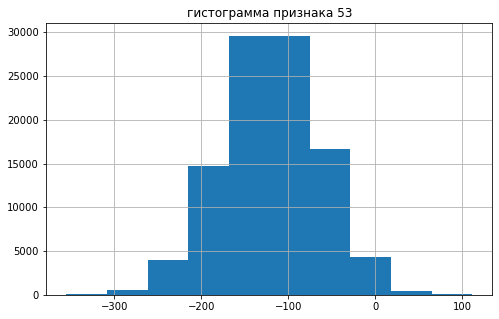

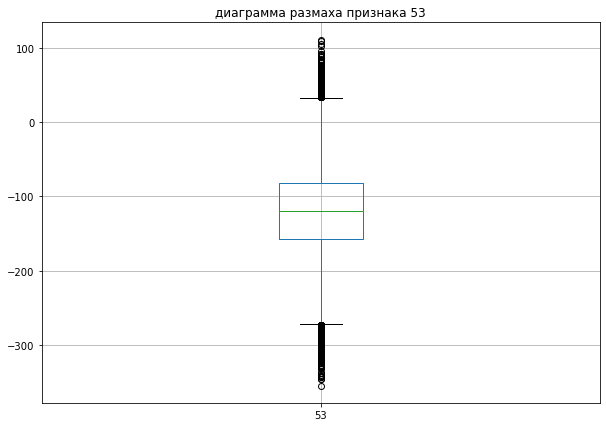

аномальные заначения признака 53: > 33.25325250000003, < -272.6392875
Данные признака 54
count    100000.000000
mean         88.193676
std           4.824051
min          66.068665
25%          84.912363
50%          88.187425
75%          91.454090
max         107.387540
Name: 54, dtype: float64


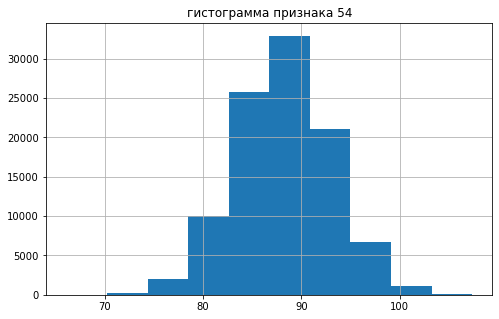

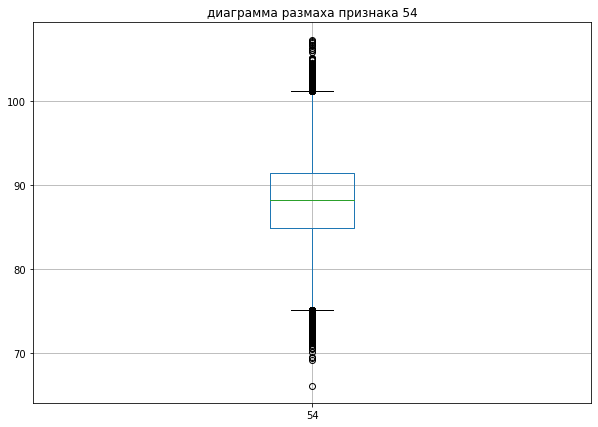

аномальные заначения признака 54: > 101.26668124999998, < 75.09977125
Данные признака 55
count    100000.000000
mean         69.538752
std          12.339684
min          18.104557
25%          61.211434
50%          69.655090
75%          77.978010
max         116.727646
Name: 55, dtype: float64


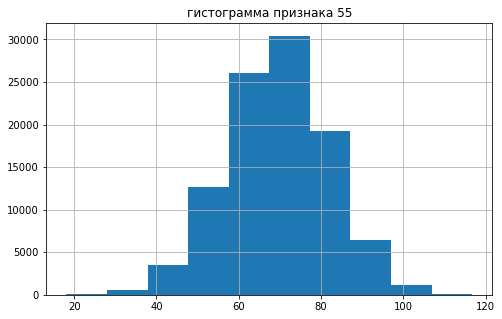

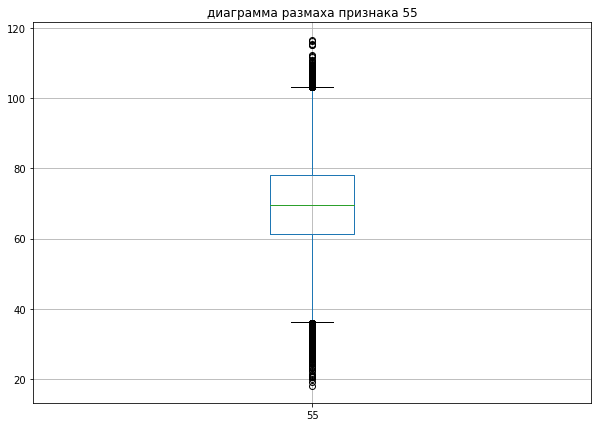

аномальные заначения признака 55: > 103.127873625, < 36.061570624999995
Данные признака 56
count    100000.000000
mean       -132.336967
std           7.952113
min        -161.189320
25%        -137.752178
50%        -132.256440
75%        -126.864683
max         -99.661170
Name: 56, dtype: float64


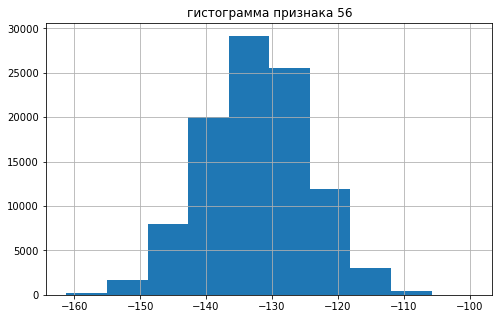

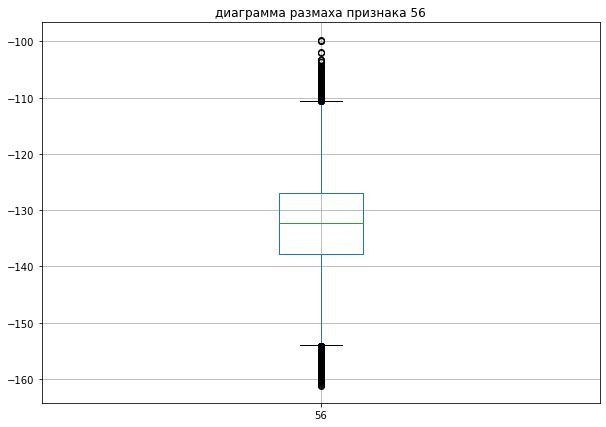

аномальные заначения признака 56: > -110.53344249999998, < -154.08341850000005
Данные признака 57
count    100000.000000
mean         14.452681
std          49.234745
min        -183.849880
25%         -19.537687
50%          13.610872
75%          48.039566
max         193.693500
Name: 57, dtype: float64


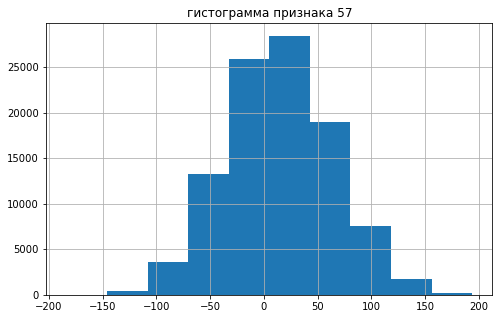

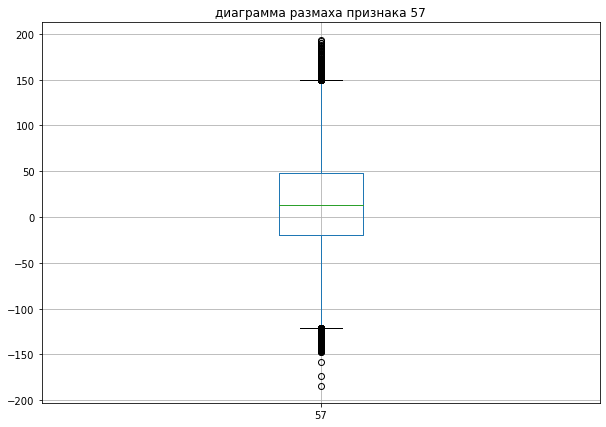

аномальные заначения признака 57: > 149.405444625, < -120.903566375
Данные признака 58
count    100000.000000
mean       -120.301843
std          55.730177
min        -330.638180
25%        -158.719347
50%        -120.229032
75%         -81.684710
max         107.606250
Name: 58, dtype: float64


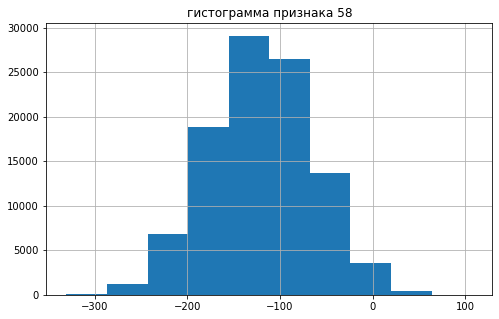

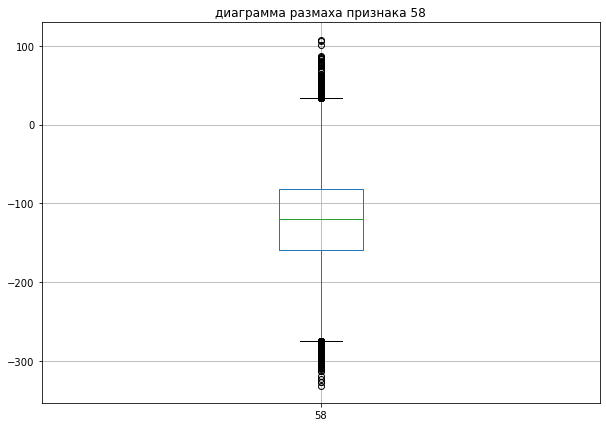

аномальные заначения признака 58: > 33.86724625000001, < -274.27130375
Данные признака 59
count    100000.000000
mean       -315.282239
std         210.657513
min        -681.029305
25%        -497.152639
50%        -315.177219
75%        -132.410422
max          48.723814
Name: 59, dtype: float64


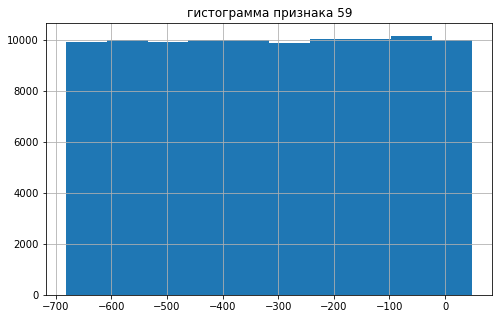

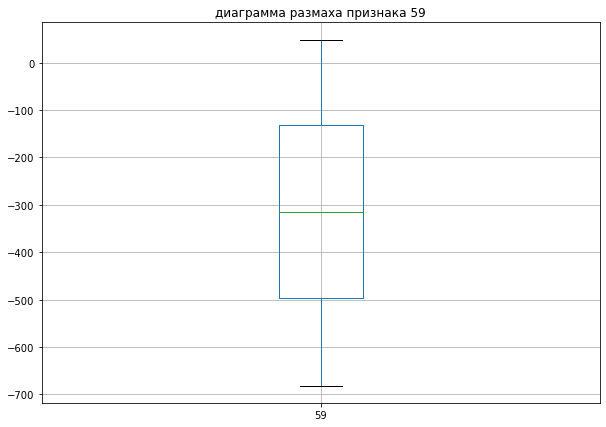

аномальные заначения признака 59: > 414.70290348061246, < -1044.26596459197
Данные признака 60
count    100000.000000
mean        -66.378660
std          64.913422
min        -358.460450
25%        -110.071390
50%         -65.254957
75%         -21.824901
max         189.175500
Name: 60, dtype: float64


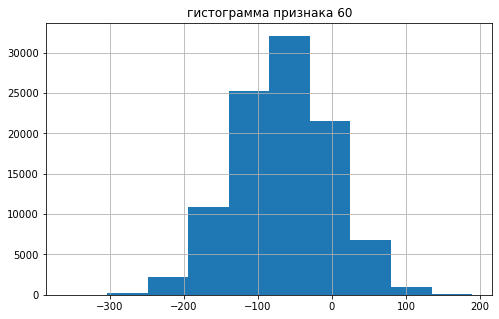

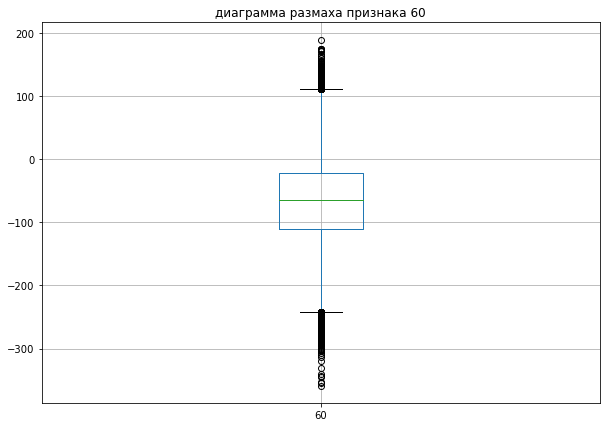

аномальные заначения признака 60: > 110.54483312500001, < -242.44112387500002
Данные признака 61
count    100000.000000
mean       -130.672183
std           9.408099
min        -169.566400
25%        -137.069838
50%        -130.803775
75%        -124.460043
max         -92.037040
Name: 61, dtype: float64


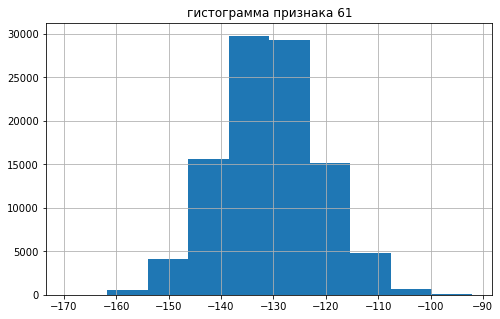

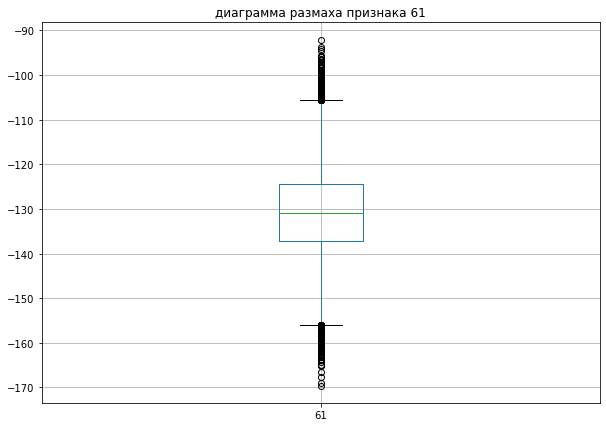

аномальные заначения признака 61: > -105.545350625, < -155.98452962500002
Данные признака 62
count    100000.000000
mean        -81.145553
std          30.675871
min        -210.059310
25%        -101.504830
50%         -80.859640
75%         -60.492451
max          47.733450
Name: 62, dtype: float64


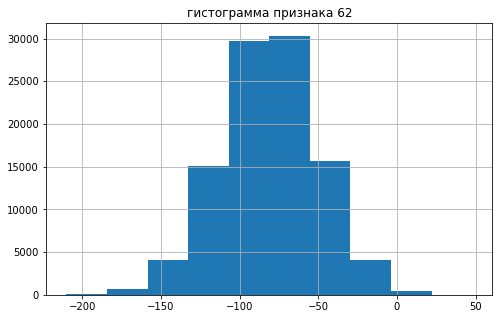

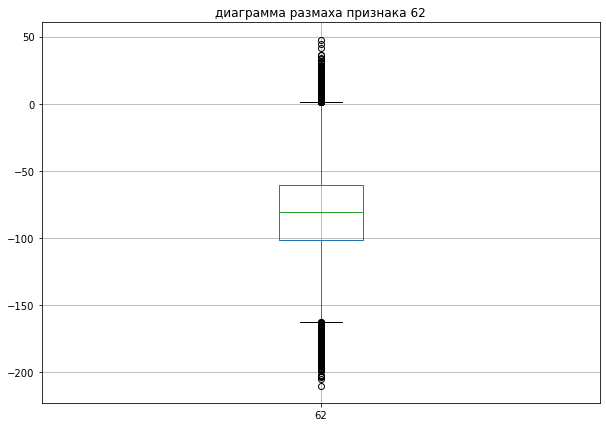

аномальные заначения признака 62: > 1.0261187499999878, < -163.02339924999998
Данные признака 63
count    100000.000000
mean         36.898233
std          25.357686
min         -60.779335
25%          19.774804
50%          36.711365
75%          53.919520
max         145.667130
Name: 63, dtype: float64


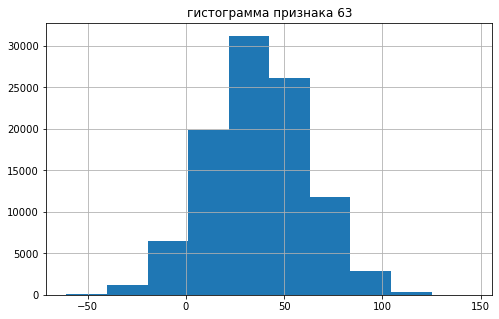

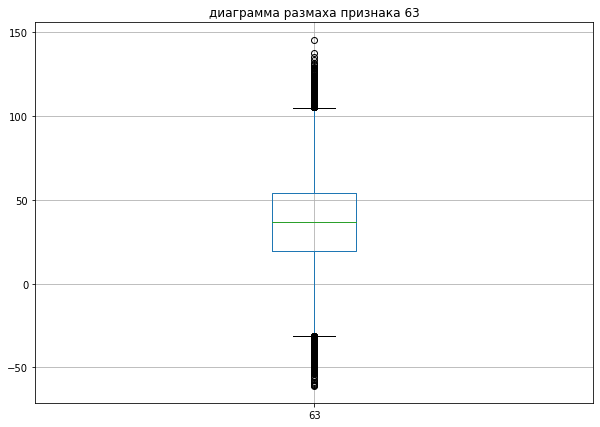

аномальные заначения признака 63: > 105.13659475, < -31.44227125
Данные признака 64
count    100000.000000
mean       -152.223082
std          41.020285
min        -317.831670
25%        -178.929470
50%        -151.576985
75%        -124.436974
max          11.907364
Name: 64, dtype: float64


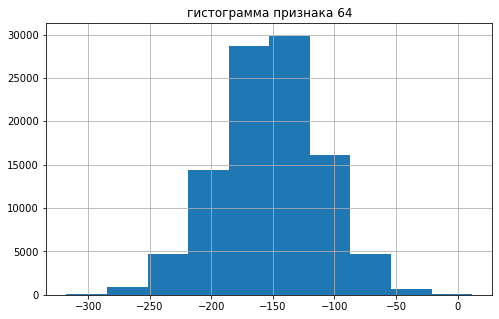

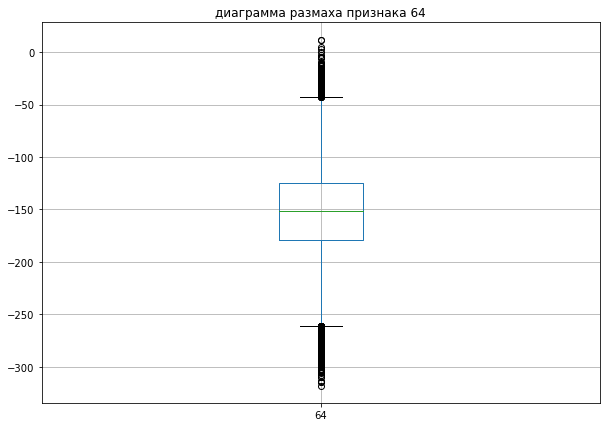

аномальные заначения признака 64: > -42.69822999999997, < -260.66821400000003
Данные признака 65
count    100000.000000
mean         14.001695
std          99.079597
min        -157.590189
25%         -71.745018
50%          14.072663
75%         100.011024
max         185.095137
Name: 65, dtype: float64


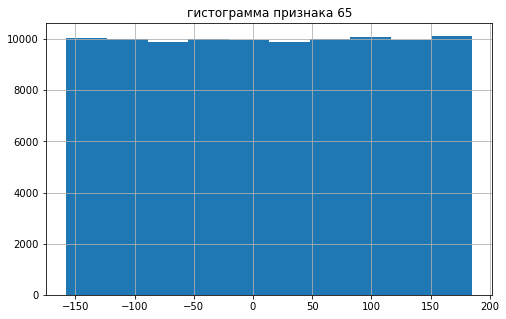

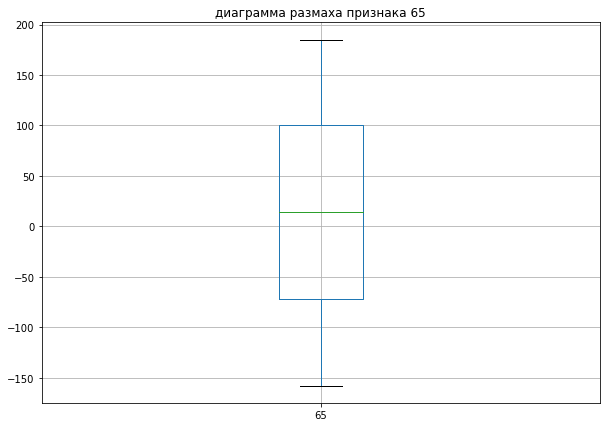

аномальные заначения признака 65: > 357.6450875263555, < -329.3790809238635
Данные признака 66
count    100000.000000
mean         67.799560
std           1.838012
min          60.668890
25%          66.560655
50%          67.813585
75%          69.058750
max          74.779884
Name: 66, dtype: float64


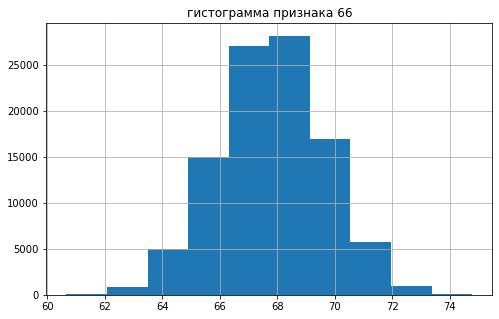

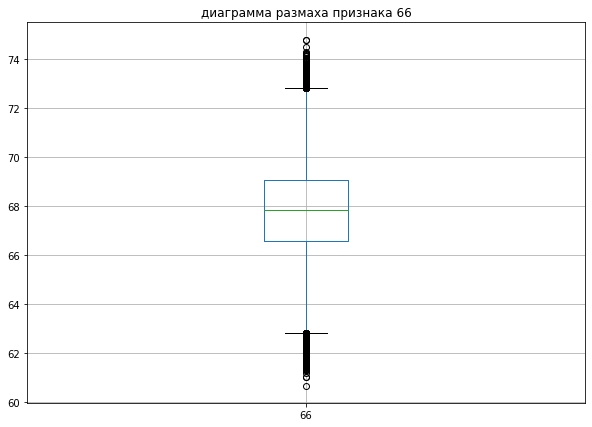

аномальные заначения признака 66: > 72.80589250000001, < 62.81351249999999
Данные признака 67
count    100000.000000
mean         23.029277
std          55.470761
min        -203.746380
25%         -14.144571
50%          23.441363
75%          59.941065
max         266.493320
Name: 67, dtype: float64


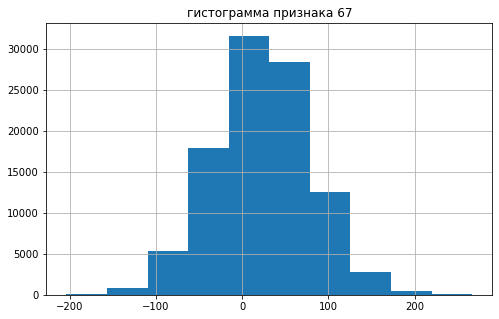

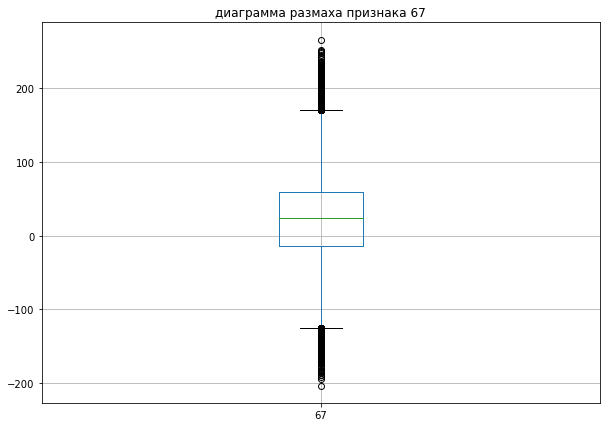

аномальные заначения признака 67: > 171.06951912500003, < -125.27302587500002
Данные признака 68
count    100000.000000
mean         73.412076
std          62.203132
min        -181.973820
25%          31.685548
50%          72.880192
75%         114.469224
max         319.867520
Name: 68, dtype: float64


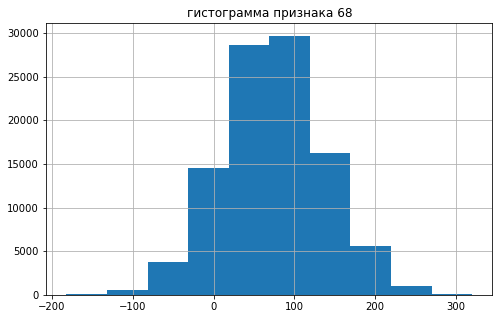

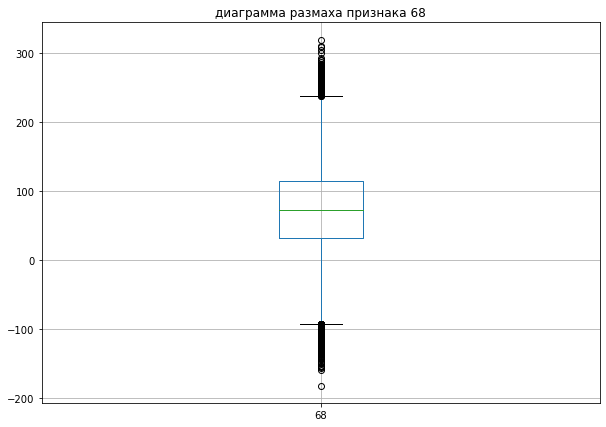

аномальные заначения признака 68: > 238.644738125, < -92.48996687500001
Данные признака 69
count    100000.000000
mean        115.189717
std          21.582238
min          22.598862
25%         100.589324
50%         115.236635
75%         129.791085
max         201.761260
Name: 69, dtype: float64


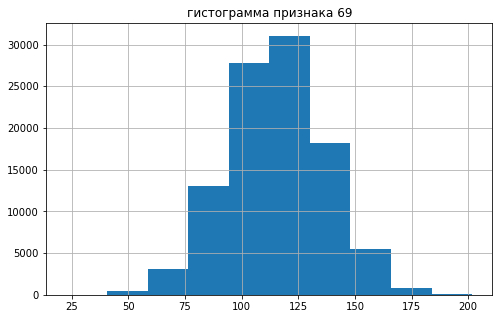

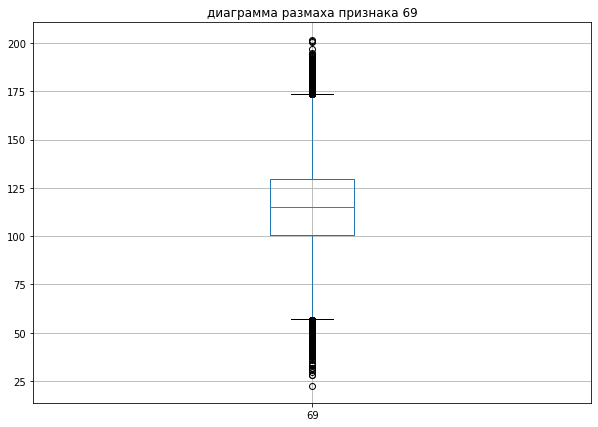

аномальные заначения признака 69: > 173.59372687500002, < 56.786681875
Данные признака 70
count    100000.000000
mean       -709.761548
std         405.961084
min       -1297.871984
25%       -1074.464888
50%        -808.801696
75%        -357.087323
max          98.768233
Name: 70, dtype: float64


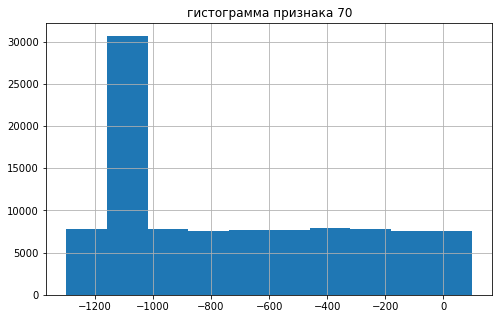

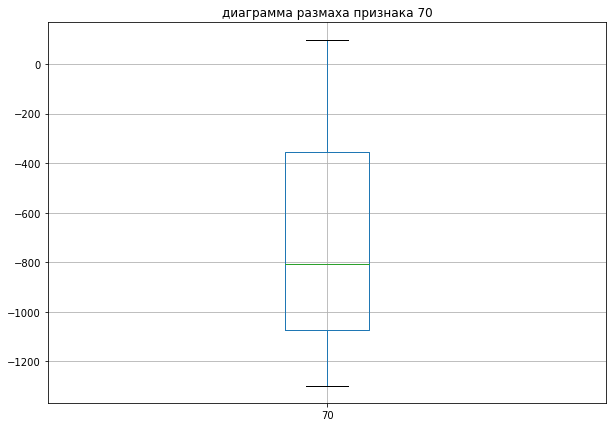

аномальные заначения признака 70: > 718.9790239774254, < -2150.5312350167615
Данные признака 71
count    100000.000000
mean        -48.505704
std          41.215124
min        -209.935760
25%         -76.478591
50%         -48.700929
75%         -20.487869
max         126.191790
Name: 71, dtype: float64


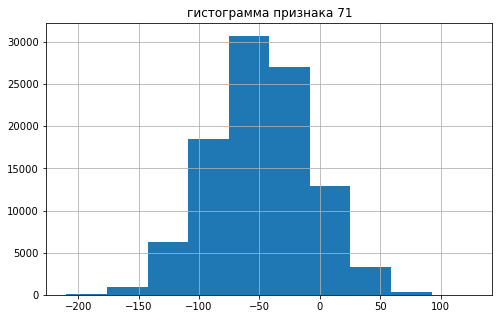

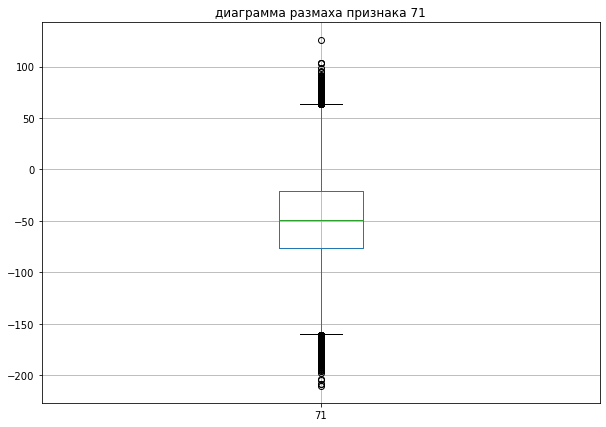

аномальные заначения признака 71: > 63.498213750000005, < -160.46467425000003


In [43]:
for i in range(72):
    data_information(data_train.columns[i])

**выводы**
после первоначального изучения данных мы пришли к тому, что:
+ данные не коррелируют между собой.
+ все признаки имеют нормальное распределения кроме признаков 6, 21, 25, 33, 44, 59, 65, 70.
+ данные имеют аномальные значения, но пока удалять их не будем.
+ признаки 59, 65 имеют почти равномерное распределение, так что можем в дальнейшем от них избавится.

### выявление дубликатов

In [22]:
data_train.duplicated().sum()

0

In [23]:
data_base.duplicated().sum()

0

In [26]:
data_train.index.duplicated().sum()

0

явные дубликаты отсутствуют.

### выявление пропусков

In [37]:
for i in range(72):
    print(i, data_train[str(i)].isna().sum())

0 0
1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0


пропуски отсутствуют.

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Нет разделения на обзор данных из файла и EDA. Лучше сделать отддельные разделы, чтобы было проще ориентировать тому, кто изучает работу.
    
Обзор данных из файла выполнен не полностью. Нужно проверить явные дубликаты, наличие прпоусков. Для того, чтобы ничего не забыть ,можно сделать функцию для обзора данных из файла. Сделав ее один раз, можешь переносить из проекта в проект. Так ты покажешь потенциальному работодателю, что автоматизируешь рутинные процессы, умеешь пользоваться функциями. 
    
Ячейка выше, в которой весь EDA и есть, запустилась с ошибкой, проверь этот омент, пожалуйста. Постарайся сделать ее вывод более удобнымм - один параметр и по нему все, что ты считаешь правильным вывести

### выводы по разделу

в этом разделе проведено следующая работа:
- загруженны данные проекта
- проведена ознакомление с данными,
- проведена исследование на наличия дубликатов и пропусков.

в результате мы получили:
- Данные не имеют некого понятного смысла,
- данные не коррелируют между собой.
- все признаки имеют нормальное распределения кроме признаков 6, 21, 25, 33, 44, 59, 65, 70.
- данные имеют аномальные значения, но пока удалять их не будем.
- признаки 59, 65 имеют почти равномерное распределение, так что можем в дальнейшем от них избавится.
- явные дубликаты отсутствуют
- пропуски отсутствуют

## K-Means

In [46]:
target_train = data_train['Target']
features_train = data_train.drop(['Target'], axis=1)

In [54]:
features_train.loc['0-query',:]

0     -53.882748
1      17.971436
2     -42.117104
3    -183.936680
4     187.517490
         ...    
67     34.457500
68     62.642094
69    134.763600
70   -415.750254
71    -25.958572
Name: 0-query, Length: 72, dtype: float64

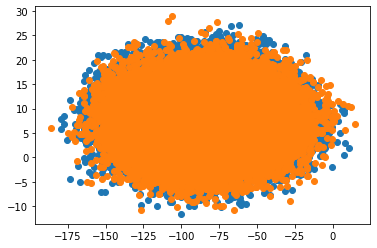

In [57]:
# define the model
kmeans_model = KMeans(n_clusters=2)

# assign each data point to a cluster
kmeans_model = kmeans_model.fit(features_train)
kmeans_result = kmeans_model.predict(features_train)
# get all of the unique clusters
kmeans_clusters = np.unique(kmeans_result)
# plot the DBSCAN clusters
for kmeans_cluster in kmeans_clusters:
    # get data points that fall in this cluster
    index = np.where(kmeans_result == kmeans_cluster)
    index = ['{}-query'.format(i) for i in index[0]]
    # make the plot
    plt.scatter(features_train.loc[index, '0'], features_train.loc[index, '1'])

# show the DBSCAN plot
plt.show()

**метрики оценки**

*Коэффициент силуэта* - этот показатель измеряет, насколько хорошо каждая точка данных вписывается в назначенный ей кластер, и находится в диапазоне от -1 до 1. Высокий коэффициент силуэта указывает на то, что точки данных хорошо кластеризованы, а низкий коэффициент указывает на то, что точки данных могут быть назначены. в неправильный кластер.
*Индекс Дэвиса-Булдина* - этот показатель измеряет среднее сходство между каждым кластером и его наиболее похожим кластером с учетом размера кластеров. Низкий индекс Дэвиса-Булдина указывает на то, что кластеры хорошо разделены и различимы.

In [58]:
labels = kmeans_model.labels_
# assign each data point to a cluster
silhouette_score_0 = silhouette_score(features_train, labels)

In [59]:
print(silhouette_score_0)

0.2015330039875651


In [60]:
davies_bouldin_score_0 = davies_bouldin_score(features_train, labels)
print(davies_bouldin_score_0)

1.8873711283804144


подбераем лучшее количество кластеров на основе этих двух показателей.

In [ ]:
best_silhouette_score = 1000
best_davies_bouldin_score = 1000
itr_silhouette = 1000
itr_davies_bouldin = 1000
for i in range(2, 100):
    kmeans_model = KMeans(n_clusters=i).fit(features_train)
    labels = kmeans_model.labels_
    silhouette_score_0 = silhouette_score(features_train, labels)
    davies_bouldin_score_0 = davies_bouldin_score(features_train, labels)
    if silhouette_score_0 > best_silhouette_score:
        best_silhouette_score = silhouette_score_0
        itr_silhouette = i
    if davies_bouldin_score_0 < best_davies_bouldin_score:
        best_davies_bouldin_score = davies_bouldin_score_0
        itr_davies_bouldin = i
    print('количество кластеров = {}, silhouette_score = {}, davies_bouldin_score = {}'.format(i, silhouette_score_0, davies_bouldin_score_0))
    

замечаем что лучший результат по метрикам качества получаем при количество кластеров = 3

подбераем лучшее количество итерации на основе этих двух показателей.

In [ ]:
best_silhouette_score = 1000
best_davies_bouldin_score = 1000
itr_silhouette = 1000
itr_davies_bouldin = 1000
for i in range(100, 1501, 100):
    kmeans_model = KMeans(n_clusters=3, max_iter=i).fit(features_train)
    labels = kmeans_model.labels_
    silhouette_score_0 = silhouette_score(features_train, labels)
    davies_bouldin_score_0 = davies_bouldin_score(features_train, labels)
    if silhouette_score_0 > best_silhouette_score:
        best_silhouette_score = silhouette_score_0
        itr_silhouette = i
    if davies_bouldin_score_0 < best_davies_bouldin_score:
        best_davies_bouldin_score = davies_bouldin_score_0
        itr_davies_bouldin = i
    print('количество итерации = {}, silhouette_score = {}, davies_bouldin_score = {}'.format(i, silhouette_score_0, davies_bouldin_score_0))

замечаем что лучший результат по метрикам качества получаем при количество итирации = 200

In [61]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [62]:
knn_model.fit(features_train, target_train)

KNeighborsClassifier()

In [64]:
result = knn_model.predict([features_train.loc['0-query']])

In [65]:
print(result)

['1496454-base']


In [67]:
result = knn_model.kneighbors([features_train.loc['0-query']])

In [68]:
print(target_train[result[1][0]])

Id
0-query         675816-base
33863-query     263833-base
92923-query     990603-base
55069-query    4552359-base
82894-query    1496454-base
Name: Target, dtype: object


In [69]:
target_train[0]

'675816-base'

In [70]:
result = knn_model.kneighbors(features_train)

In [71]:
%%time
result = knn_model.predict(features_train)

CPU times: total: 4min 37s
Wall time: 2min 6s


In [72]:
result

array(['1496454-base', '1092952-base', '1447819-base', ...,
       '2056751-base', '1050170-base', '1490663-base'], dtype=object)

In [73]:
accuracy_score(result,target_train)

0.22597

<div class="alert alert-info">
<b>Комментарий ревьювера:</b>  Напиши, пожалуйста вывод. Что было сделано? С какой целью? Какой получен результат? Вывод не менее важен, чем написано кода. Часто в код не вчитываются, а вот вывод как раз и проверяют

### выводы по разделу

в этом разделе проведено следующая работа:
- обучена модель kmeans с 2-мя кластерами
- подобрены лучшие гиперпараметри kmeans (количество кластеров, количество итирации) на основе 2 показателя (Коэффициент силуэта, Индекс Дэвиса-Булдина),
- лучшие результаты получены при количество кластеров=3 и количество итирации=200.
- обучена модель KNeighborsClassifier.
- точность решения задачи с использованием kmeans и KNeighborsClassifier составили 22,5 %, что является очень незкой.

в следующие разделе попытаемя решить задачу с использованием адгоритма FAISS.

## FAISS

In [ ]:
K_NEIGHBORS = 5

In [ ]:
NUM_SAMPLES = 50000

In [ ]:
def acc_5(targets, indices, base_indices):
    """ Функция для расчета значения метрики accuracy
        входные параметры функции:
        targets - вектор целевого признака
        indices - матрица индексов найденных ближайших соседей
        base_index - словарь базовых индексов """
    
    acc = 0 # начальное значение метрики
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in el])

    return 100 * acc / len(indices)

In [ ]:
def faiss_model(data_base, data_train, num_samples=None):
    dims = data_base.shape[1] # размерность вектора признаков для каждого объекта
    n_cells = 50 # количество кластеров (ячейки Воронова?)
    quantizer = faiss.IndexFlatL2(dims) # квантователь 
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
    idx_l2.train(np.ascontiguousarray(data_base.values[:num_samples, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data_base.values).astype('float32'))
    base_index = {k: v for k, v in enumerate(data_base.index.to_list())}
    y_train = data_train['Target'] # целевой признак обучающей выборки
    X_train = data_train.drop('Target', axis=1) # обучающая выборка
    r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
    accuracy = acc_5(y_train, idx, base_index)
    print(accuracy, '%')

In [ ]:
faiss_model(data_base, data_train, NUM_SAMPLES)

## EDA

In [ ]:
df_samples = data_train[:NUM_SAMPLES]

In [ ]:
df_samples.hist(figsize=[20, 20], bins=50);

In [ ]:
data_to_drop = ['6', '21', '25', '33', '44', '59', '65', '70']
for i in data_to_drop:
    data_base_new = data_base.drop(i, axis=1)
    X_train_new = data_train.drop(i, axis=1) # обучающая выборка
    print('при улаления столбца {} точность будет'.format(i))
    faiss_model(data_base_new, X_train_new, NUM_SAMPLES)

замечаем что при удаления столбцов 33, 44 и 59 повышается точность.

In [ ]:
col_to_delet = ['33', '44', '59']
data_base_new = data_base.drop(col_to_delet, axis=1)
X_train_new = data_train.drop(col_to_delet, axis=1)
X_validation_new = data_validation.drop(col_to_delet, axis=1).reset_index()
faiss_model(data_base_new, X_train_new, NUM_SAMPLES)

### Нормализация (масштабирование) численных признаков

In [ ]:
scaler = StandardScaler()
num_cols = X_train_new.select_dtypes(include='number').columns # численные признаки
# обучим базовую выборку с отмасштабированными численными признаками


In [ ]:
X_base_normal_SS = pd.DataFrame(scaler.fit_transform(data_base_new[num_cols]), index=data_base_new.index, columns=num_cols)
X_train_normal_SS = pd.DataFrame(scaler.transform(X_train_new[num_cols]), index=X_train_new.index, columns=num_cols)
X_train_normal_SS['Target'] = data_train['Target']
X_validation_normal_SS = pd.DataFrame(scaler.transform(X_validation_new[num_cols]), index=X_validation_new.index, columns=num_cols)

In [ ]:
faiss_model(X_base_normal_SS, X_train_normal_SS, NUM_SAMPLES)

замечаем что точность модели повышается поле нормализации данных с используванием стандартного нормализатора.

In [ ]:
scaler = RobustScaler()

In [ ]:
X_base_normal_RS = pd.DataFrame(scaler.fit_transform(data_base_new[num_cols]), index=data_base_new.index, columns=num_cols)
X_train_normal_RS = pd.DataFrame(scaler.transform(X_train_new[num_cols]), index=X_train_new.index, columns=num_cols)
X_train_normal_RS['Target'] = data_train['Target']
X_validation_normal_RS = pd.DataFrame(scaler.transform(X_validation_new[num_cols]), index=X_validation_new.index, columns=num_cols)

In [ ]:
faiss_model(X_base_normal_RS, X_train_normal_RS, NUM_SAMPLES)

StandardScaler дает лучше результатов чем RobustScaler.

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> StandardScaler() - это стандартизация

### удаление выбросов

In [ ]:
X_train_normal_SS_all = X_train_normal_SS.copy()
for column in X_train_normal_SS.columns:
    if column in ['6', '21', '25', '33', '44', '59', '70', 'Target']:
        continue
    Q1 = X_train_normal_SS[column].quantile(0.25)
    Q3 = X_train_normal_SS[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # data frame with deleted unwanted values from only one column
    X_train_normal_SS_column = X_train_normal_SS[~((X_train_normal_SS[column] > (Q3 + 1.5 * IQR)) | 
                                          (X_train_normal_SS[column] < (Q1 - 1.5 * IQR)))]
    # data frame with deleting all the unwanted values
    X_train_normal_SS_all = X_train_normal_SS_all[~((X_train_normal_SS[column] > (Q3 + 1.5 * IQR)) | 
                                          (X_train_normal_SS[column] < (Q1 - 1.5 * IQR)))]
    
    # calculate the accuracy of data frame with deleted unwanted values from only one column 
    print('при улаления выбросов столбца {} точность будет'.format(column))
    faiss_model(X_base_normal_SS, X_train_normal_SS_column, 10000)

замечаем что пре удаления выбросов из одного признака точность моделе может повысется на 0,5%

In [ ]:
X_train_normal_SS_all.info()

In [ ]:
faiss_model(X_base_normal_SS, X_train_normal_SS_all, NUM_SAMPLES)

замечаем что точность повышается на 0,3% при удалении все данные с выбросами.

### исследование гиперпараметров FAISS

In [ ]:
# диапазоны значений параметров алгоритма
n_cells_array = range(50, 201, 50)
nprobe_array = range(1, 20, 4)
best_n_cells = 1
best_nprobe = 1
best_acc_5 = 0
best_distx = []
best_idx = []

In [ ]:
def faiss_model_hyper(data_base, data_train, num_samples=None, n_cells=None, nprobe=None):
    dims = data_base.shape[1] # размерность вектора признаков для каждого объекта
    quantizer = faiss.IndexFlatL2(dims) # квантователь 
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
    idx_l2.train(np.ascontiguousarray(data_base.values[:num_samples, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data_base.values).astype('float32'))
    idx_l2.nprobe = nprobe 
    base_index = {k: v for k, v in enumerate(data_base.index.to_list())}
    y_train = data_train['Target'] # целевой признак обучающей выборки
    X_train = data_train.drop('Target', axis=1) # обучающая выборка
    r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
    accuracy = acc_5(y_train, idx, base_index)
    return idx_l2, accuracy

In [ ]:
n_iter = 1
for n_cells in n_cells_array:
    for nprobe in nprobe_array:
        idx_l2, acc = faiss_model_hyper(X_base_normal_SS, X_train_normal_SS_all, NUM_SAMPLES, n_cells, nprobe)
        print('iteration...', n_iter, 'n_cells...', n_cells, 'nprobe...', nprobe,
              'acc@5...', acc)
        n_iter += 1
        if acc > best_acc_5:
            best_acc_5 = acc
            best_n_cells = n_cells
            best_nprobe = nprobe

print('best acc@5:', best_acc_5, '%')
print('best_n_cells:', best_n_cells)
print('best_nprobe:', best_nprobe)

замечаем что самый лучший результат является 68.98% при n_cells = 50 и nprobe = 17.

### вывод 
По результатам проведенных исследований можно сделать следующие предварительные выводы:

- замечаем что точность повышается на 0,3% при удалении все данные с выбросами.
- точность модели повышается после нормализации данных с используванием стандартного нормализатора.
- удаления столбцов 33, 44 и 59 повышается точность.
- согласно проведенным исследованиям, наилучшие результаты дают значения n_cells = 50 nprobe = 17 (68.98%), 

### тестирования лучшей модели на валидационной выброке

In [ ]:
%%time
idx_l2, acc = faiss_model_hyper(X_base_normal_SS, X_train_normal_SS_all, num_samples=None, n_cells=50, nprobe=17)

In [ ]:
acc

In [ ]:
def acc_5(targets, indices, base_indices):
    """ Функция для расчета значения метрики accuracy
        входные параметры функции:
        targets - вектор целевого признака
        indices - матрица индексов найденных ближайших соседей
        base_index - словарь базовых индексов """
    
    acc = 0 # начальное значение метрики
    for target, el in zip(targets.values.tolist(), indices.tolist()):
        acc += int(target in [base_indices[r] for r in el])

    return 100 * acc / len(indices)

In [ ]:
def faiss_model_hyper(data_base, data_train, num_samples=None, n_cells=None, nprobe=None):
    dims = data_base.shape[1] # размерность вектора признаков для каждого объекта
    quantizer = faiss.IndexFlatL2(dims) # квантователь 
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells) # создание индекса с кластеризацией
    idx_l2.train(np.ascontiguousarray(data_base.values[:num_samples, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(data_base.values).astype('float32'))
    idx_l2.nprobe = nprobe 
    base_index = {k: v for k, v in enumerate(data_base.index.to_list())}
    y_train = data_train['Target'] # целевой признак обучающей выборки
    X_train = data_train.drop('Target', axis=1) # обучающая выборка
    r, idx = idx_l2.search(np.ascontiguousarray(X_train.values).astype('float32'), K_NEIGHBORS)
    accuracy = acc_5(y_train, idx, base_index)
    return idx_l2, accuracy

In [ ]:
r, idx = idx_l2.search(np.ascontiguousarray(X_validation_normal_SS.values).astype('float32'), K_NEIGHBORS)
base_index = {k: v for k, v in enumerate(X_base_normal_SS.index.to_list())}
accuracy = acc_5(data_validation_answer, idx, base_index)
print(accuracy, '%')

**Я здесь не понял в чём проблема!!!**

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Перепроверь, пожалуйста, код в этом разделе. Часто ошибка незначительна, но в корне меняет все решение задачи. Если не получится - попробуй заново переписать этот раздел.

## Общий вывод

По результатам проведенной работы с помощью библиотеки FAISS был разработан и протестирован алгоритм мэтчинга товаров, позволяющий каждому товару из валидационной выборки выборки сопоставить наиболее близкие товары из базовой выборки (по заданной метрике качества - acc@5).<br>
При решении данной задачи были выполнены следующие работы:
- проведен первичиный исследовательский анализ и предобработка данных исходных датасетов;
- найдены признаки, имеющие отличное от нормального распределения (под номерами 6, 21, 25, 33, 44, 59, 65 и 70), которые, скорее всего, являются препятствием для успешного обучения индекса FAISS (и последующего поиска похожих товаров) и возможных применяемых моделей;
- из этих признаков удалено  33, 44, 59 потому что они имели вредное влияние на обучения модели,
- повторено базовое решение (бейзлайн) задачи мэтчинга, давшее ок. 8.6 % качество;
- проведена нормализация (масштабирование/стандартизация) признаков с помощью базового инструмента StandardScaler;
- проведена проверка данных на коллинеарность, получено макс. значение коэффициента фи-корреляции $\phi_K$, равное 0.4276 - такая слабая линейная зависимость признаков не позволила нам сделать математический вывод о возможности удаления каких-либо признаков из выборок;
- проверено качество решения задачи поиска похожих товаров для отмасштабированных (скэйлированых) данных, которая показала, что только лишь одна нормализация позволила повысить качество решения задачи мэтчинга с 8.693 %  до 58.981 % - более, чем в 6 раз, что уже является неплохим результатом (при прочих равных условиях);
- проведено исследование гиперпараметров алгоритма (функций библиотеки FAISS), таких как, количество кластеров, на которые разбивается выборка (n_cells) и количество соседних кластеров, в которых осуществляется поиск после разбиения на n_cells кластеров и нахождения центроидов данных кластеров (nprobe). 
- в неких небольших диапазонах изменения указанных параметров, наилучшие результаты дают значения n_cells = 50, nprobe = 17 (65.9 %), 
- обучения на всех экземпляров с оптимально модели дала точность = 69.27% на обучающую выборку, однак на валидационную выборку дала 0% (не нашел в чем проблема)

<div class="alert alert-info">
<b>Комментарий ревьювера:</b> Фирас, спасибо за проект! Главное - сделай так, чтобы он запускался, сейчас в EDA ошибка, которая не дает запустить весь код. Выше посоветовал, что нужно сделать, чтобы исправить ошибку с низким показателем метрики. Также обрати вниание на обзор данных из файла - хоть это и подготовительная фаза работы, но не менее важная